# **AI LAB 2023**<a href="#AI-LAB-2023" class="anchor-link">¶</a>

### A. Calderoni, A. Fabbricatore, S. Mancini, A. Pranzo, B. Zanini<a
href="#A.-Calderoni,-A.-Fabbricatore,-S.-Mancini,-A.-Pranzo,-B.-Zanini"
class="anchor-link">¶</a>

## Experimental Background<a href="#Experimental-Background" class="anchor-link">¶</a>

**Definitions**

-   Hypoxia: "depleted" oxygen levels in tissue culture flasks, i.e.
    about 2% oxygen
-   Normoxia: “normal” oxygen levels in tissue culture flasks, i.e.
    about 20–21% oxygen

**Why is it important to study whether cells are hypoxia or normoxia?**

Cancer cells are cells which grow excessively and refuse to die, but
rather keep increasing in number. Specifically, they require more oxygen
than other "normal" cells but there are problems occuring when
metastases occupy large areas as blood vessels are incapable of
supplying sufficient oxygen to that area. The result is that cancer
cells will adapt (become hypoxia cells) in order to survive under the
harsher low oxygen conditions. Hypoxia cancer cells are much more
aggressive and difficult to treat - a greater ability to distinguish
them early on would allow, potentially, better treatment in response to
the cancer.

**Data Experimental Design**

In our experiment, we grow certain cells in one environment with normal
oxygen levels (21%) and other cells in an environment with lower oxygen
levels (1% of oxygen). Then, using the Smart-Seq and Drop-Seq
technologies for single-cell RNA sequencing, we sequenced each and every
cell. Both of these sequencing approaches were used on the HCC1086 and
MCF7 cell lines. Particularly they are cell lines corresponding to
different breast cancers - ASCC and adenocarcinoma1 respectively.

**Data Structure**

There are two main types of files: data and metadata.

Data: The raw unfiltered data used is organised in .txt files whereby
the naming conventions is the following:
{cell_type}/{sequencing_technique}/{data_type}. They are made in such a
way that cell names are the columns and genes are the rows with each
value in the dataframe being the "amount" of that gene present in the
cell.

Metadata: The metadata used is organised in .tsv files whereby the
naming conventions is the following: {cell_type}/{sequencing_technique}.
Each row in the dataframe represents a cell and each column represents a
general attribute about it - with a relevant one being our target
variable "Pos Condition".

**Aim of our Project**

Our goal is to develop a solid predictor from data that can determine
whether a cell was living in a hypoxic or normal environment based on
its gene expression.

**Important**

Numerically, hypoxia will be represented as 0 and normoxia as 1.

In \[ \]:

    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    from scipy.stats import kurtosis, skew
    from sklearn.decomposition import PCA
    from fix_data import add_label_T
    from sklearn.manifold import MDS
    from sklearn.manifold import Isomap
    from sklearn.manifold import TSNE
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import StandardScaler
    from sklearn.svm import SVC
    from lightgbm import LGBMClassifier

## Exploratory Data Analysis and Cleaning<a href="#Exploratory-Data-Analysis-and-Cleaning"
class="anchor-link">¶</a>

In \[ \]:

    unfilt_hcc_smarts = pd.read_csv("data/smartSeq/HCC1806_SmartS_Unfiltered_Data.txt", sep = " ")
    meta_hcc_smarts = pd.read_table("data/smartSeq/HCC1806_SmartS_MetaData.tsv")

    unfilt_mcf_smarts = pd.read_csv("data/smartSeq/MCF7_SmartS_Unfiltered_Data.txt", sep = " ")
    meta_mcf_smarts = pd.read_table("data/smartSeq/MCF7_SmartS_MetaData.tsv")

As aforementioned, the metadata file contains general information about
each cell, as can be seen in the code below. With the *Condition* column
being our target for the overall project.

In \[ \]:

    meta_hcc_smarts

Out\[ \]:

|     | Filename                                          | Cell Line | PCR Plate | Pos | Condition | Hours | Cell name | PreprocessingTag              | ProcessingComments |
|-----|---------------------------------------------------|-----------|-----------|-----|-----------|-------|-----------|-------------------------------|--------------------|
| 0   | output.STAR.PCRPlate1A10_Normoxia_S123_Aligned... | HCC1806   | 1         | A10 | Normo     | 24    | S123      | Aligned.sortedByCoord.out.bam | STAR,FeatureCounts |
| 1   | output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.... | HCC1806   | 1         | A12 | Normo     | 24    | S26       | Aligned.sortedByCoord.out.bam | STAR,FeatureCounts |
| 2   | output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.so... | HCC1806   | 1         | A1  | Hypo      | 24    | S97       | Aligned.sortedByCoord.out.bam | STAR,FeatureCounts |
| 3   | output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s... | HCC1806   | 1         | A2  | Hypo      | 24    | S104      | Aligned.sortedByCoord.out.bam | STAR,FeatureCounts |
| 4   | output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor... | HCC1806   | 1         | A3  | Hypo      | 24    | S4        | Aligned.sortedByCoord.out.bam | STAR,FeatureCounts |
| ... | ...                                               | ...       | ...       | ... | ...       | ...   | ...       | ...                           | ...                |
| 238 | output.STAR.PCRPlate4H10_Normoxia_S210_Aligned... | HCC1806   | 4         | H10 | Normo     | 24    | S210      | Aligned.sortedByCoord.out.bam | STAR,FeatureCounts |
| 239 | output.STAR.PCRPlate4H11_Normoxia_S214_Aligned... | HCC1806   | 4         | H11 | Normo     | 24    | S214      | Aligned.sortedByCoord.out.bam | STAR,FeatureCounts |
| 240 | output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.s... | HCC1806   | 4         | H2  | Hypo      | 24    | S199      | Aligned.sortedByCoord.out.bam | STAR,FeatureCounts |
| 241 | output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.... | HCC1806   | 4         | H7  | Normo     | 24    | S205      | Aligned.sortedByCoord.out.bam | STAR,FeatureCounts |
| 242 | output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.... | HCC1806   | 4         | H9  | Normo     | 24    | S236      | Aligned.sortedByCoord.out.bam | STAR,FeatureCounts |

243 rows × 9 columns

Moreover, as already discussed in the introduction, we then have the
unfiltered dataset which contains the different cells as its columns and
the count of each gene (row) respectively.

In \[ \]:

    print(f"The dimension of the unfiltered hcc1806 dataset is: {unfilt_hcc_smarts.shape}")
    print(f"The dimension of the unfiltered mcf7 dataset is: {unfilt_mcf_smarts.shape}")
    unfilt_mcf_smarts

    The dimension of the unfiltered hcc1806 dataset is: (23396, 243)
    The dimension of the unfiltered mcf7 dataset is: (22934, 383)

Out\[ \]:

|           | output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam | output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam | output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam | output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam | output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam | output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam | output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam | output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam | output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam | output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam | ... | output.STAR.4_H14_Hypo_S383_Aligned.sortedByCoord.out.bam | output.STAR.4_H1_Norm_S355_Aligned.sortedByCoord.out.bam | output.STAR.4_H2_Norm_S356_Aligned.sortedByCoord.out.bam | output.STAR.4_H3_Norm_S357_Aligned.sortedByCoord.out.bam | output.STAR.4_H4_Norm_S358_Aligned.sortedByCoord.out.bam | output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam | output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam | output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam | output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam | output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam |
|-----------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|---------------------------------------------------------|-----|-----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|
| WASH7P    | 0                                                        | 0                                                        | 0                                                        | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                       | ... | 0                                                         | 0                                                        | 0                                                        | 1                                                        | 0                                                        | 0                                                        | 0                                                        | 1                                                        | 0                                                        | 1                                                        |
| MIR6859-1 | 0                                                        | 0                                                        | 0                                                        | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                       | ... | 0                                                         | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        |
| WASH9P    | 1                                                        | 0                                                        | 0                                                        | 0                                                      | 0                                                      | 1                                                      | 10                                                     | 1                                                      | 0                                                      | 0                                                       | ... | 1                                                         | 1                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 1                                                        | 1                                                        | 4                                                        | 5                                                        |
| OR4F29    | 0                                                        | 0                                                        | 0                                                        | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                       | ... | 0                                                         | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 1                                                        | 0                                                        |
| MTND1P23  | 0                                                        | 0                                                        | 0                                                        | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                       | ... | 0                                                         | 0                                                        | 1                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        |
| ...       | ...                                                      | ...                                                      | ...                                                      | ...                                                    | ...                                                    | ...                                                    | ...                                                    | ...                                                    | ...                                                    | ...                                                     | ... | ...                                                       | ...                                                      | ...                                                      | ...                                                      | ...                                                      | ...                                                      | ...                                                      | ...                                                      | ...                                                      | ...                                                      |
| MT-TE     | 4                                                        | 0                                                        | 0                                                        | 0                                                      | 3                                                      | 3                                                      | 0                                                      | 0                                                      | 14                                                     | 1                                                       | ... | 0                                                         | 4                                                        | 12                                                       | 4                                                        | 0                                                        | 1                                                        | 6                                                        | 0                                                        | 7                                                        | 4                                                        |
| MT-CYB    | 270                                                      | 1                                                        | 76                                                       | 66                                                     | 727                                                    | 2717                                                   | 9326                                                   | 3253                                                   | 7949                                                   | 30                                                      | ... | 239                                                       | 3795                                                     | 12761                                                    | 2263                                                     | 1368                                                     | 570                                                      | 3477                                                     | 349                                                      | 2184                                                     | 1149                                                     |
| MT-TT     | 0                                                        | 0                                                        | 0                                                        | 0                                                      | 0                                                      | 1                                                      | 1                                                      | 1                                                      | 4                                                      | 0                                                       | ... | 0                                                         | 7                                                        | 4                                                        | 2                                                        | 0                                                        | 0                                                        | 3                                                        | 0                                                        | 2                                                        | 2                                                        |
| MT-TP     | 5                                                        | 0                                                        | 0                                                        | 1                                                      | 0                                                      | 1                                                      | 1                                                      | 4                                                      | 2                                                      | 0                                                       | ... | 0                                                         | 14                                                       | 56                                                       | 11                                                       | 2                                                        | 0                                                        | 7                                                        | 2                                                        | 28                                                       | 11                                                       |
| MAFIP     | 8                                                        | 0                                                        | 0                                                        | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 1                                                      | 0                                                      | 0                                                       | ... | 0                                                         | 0                                                        | 0                                                        | 2                                                        | 1                                                        | 0                                                        | 6                                                        | 0                                                        | 1                                                        | 4                                                        |

22934 rows × 383 columns

It is important to check whether all the values in the datasets are of
the same type, as if they aren't they'd require adaptation.

In \[ \]:

    print(f"The datatypes in the hcc1806 dataset are: {str(set([i for i in unfilt_hcc_smarts.T.dtypes]))[8:-3]}")
    print(f"The datatypes in the mcf7 dataset are: {str(set([i for i in unfilt_mcf_smarts.T.dtypes]))[8:-3]}")
    print("Hence, they are all of the same type.")

    The datatypes in the hcc1806 dataset are: int64
    The datatypes in the mcf7 dataset are: int64
    Hence, they are all of the same type.

Let's also run a .describe() of the datasets to get a more general
picture.

In \[ \]:

    print(unfilt_mcf_smarts.describe())
    print(unfilt_hcc_smarts.describe())

           output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000         \
    mean                                           40.817651          
    std                                           465.709940          
    min                                             0.000000          
    25%                                             0.000000          
    50%                                             0.000000          
    75%                                            17.000000          
    max                                         46744.000000          

           output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000         \
    mean                                            0.012253          
    std                                             0.207726          
    min                                             0.000000          
    25%                                             0.000000          
    50%                                             0.000000          
    75%                                             0.000000          
    max                                            14.000000          

           output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000         \
    mean                                           86.442400          
    std                                          1036.572689          
    min                                             0.000000          
    25%                                             0.000000          
    50%                                             0.000000          
    75%                                             5.000000          
    max                                         82047.000000          

           output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000       \
    mean                                            1.024636        
    std                                             6.097362        
    min                                             0.000000        
    25%                                             0.000000        
    50%                                             0.000000        
    75%                                             0.000000        
    max                                           289.000000        

           output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000       \
    mean                                           14.531351        
    std                                           123.800530        
    min                                             0.000000        
    25%                                             0.000000        
    50%                                             0.000000        
    75%                                             7.000000        
    max                                         10582.000000        

           output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000       \
    mean                                           56.213613        
    std                                           503.599145        
    min                                             0.000000        
    25%                                             0.000000        
    50%                                             0.000000        
    75%                                            23.000000        
    max                                         46856.000000        

           output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000       \
    mean                                           75.397183        
    std                                           430.471519        
    min                                             0.000000        
    25%                                             0.000000        
    50%                                             0.000000        
    75%                                            39.000000        
    max                                         29534.000000        

           output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000       \
    mean                                           62.767725        
    std                                           520.167576        
    min                                             0.000000        
    25%                                             0.000000        
    50%                                             1.000000        
    75%                                            35.000000        
    max                                         50972.000000        

           output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000       \
    mean                                           67.396747        
    std                                           459.689019        
    min                                             0.000000        
    25%                                             0.000000        
    50%                                             0.000000        
    75%                                            38.000000        
    max                                         36236.000000        

           output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam  ...   
    count                                       22934.000000        ...  \
    mean                                            2.240734        ...   
    std                                            25.449630        ...   
    min                                             0.000000        ...   
    25%                                             0.000000        ...   
    50%                                             0.000000        ...   
    75%                                             1.000000        ...   
    max                                          1707.000000        ...   

           output.STAR.4_H14_Hypo_S383_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000          \
    mean                                           17.362562           
    std                                           193.153757           
    min                                             0.000000           
    25%                                             0.000000           
    50%                                             0.000000           
    75%                                             9.000000           
    max                                         17800.000000           

           output.STAR.4_H1_Norm_S355_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000         \
    mean                                           42.080230          
    std                                           256.775704          
    min                                             0.000000          
    25%                                             0.000000          
    50%                                             0.000000          
    75%                                            30.000000          
    max                                         23355.000000          

           output.STAR.4_H2_Norm_S356_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000         \
    mean                                           34.692422          
    std                                           679.960908          
    min                                             0.000000          
    25%                                             0.000000          
    50%                                             0.000000          
    75%                                             0.000000          
    max                                         81952.000000          

           output.STAR.4_H3_Norm_S357_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000         \
    mean                                           32.735284          
    std                                           300.291051          
    min                                             0.000000          
    25%                                             0.000000          
    50%                                             0.000000          
    75%                                            17.000000          
    max                                         29540.000000          

           output.STAR.4_H4_Norm_S358_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000         \
    mean                                           21.992718          
    std                                           153.441647          
    min                                             0.000000          
    25%                                             0.000000          
    50%                                             0.000000          
    75%                                            12.000000          
    max                                         12149.000000          

           output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000         \
    mean                                           17.439391          
    std                                           198.179666          
    min                                             0.000000          
    25%                                             0.000000          
    50%                                             0.000000          
    75%                                             9.000000          
    max                                         19285.000000          

           output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000         \
    mean                                           49.242784          
    std                                           359.337479          
    min                                             0.000000          
    25%                                             0.000000          
    50%                                             0.000000          
    75%                                            27.000000          
    max                                         28021.000000          

           output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000         \
    mean                                           61.545609          
    std                                           540.847355          
    min                                             0.000000          
    25%                                             0.000000          
    50%                                             0.000000          
    75%                                            30.000000          
    max                                         40708.000000          

           output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam   
    count                                       22934.000000         \
    mean                                           68.289352          
    std                                           636.892085          
    min                                             0.000000          
    25%                                             0.000000          
    50%                                             0.000000          
    75%                                            38.000000          
    max                                         46261.000000          

           output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam  
    count                                       22934.000000         
    mean                                           62.851400         
    std                                           785.670341         
    min                                             0.000000         
    25%                                             0.000000         
    50%                                             0.000000         
    75%                                            33.000000         
    max                                         68790.000000         

    [8 rows x 383 columns]
           output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                     \
    mean                                           99.565695                      
    std                                           529.532443                      
    min                                             0.000000                      
    25%                                             0.000000                      
    50%                                             0.000000                      
    75%                                            51.000000                      
    max                                         35477.000000                      

           output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                    \
    mean                                          207.678278                     
    std                                           981.107905                     
    min                                             0.000000                     
    25%                                             0.000000                     
    50%                                             0.000000                     
    75%                                           125.000000                     
    max                                         69068.000000                     

           output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                  \
    mean                                            9.694734                   
    std                                            65.546050                   
    min                                             0.000000                   
    25%                                             0.000000                   
    50%                                             0.000000                   
    75%                                             5.000000                   
    max                                          6351.000000                   

           output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                   \
    mean                                          150.689007                    
    std                                           976.936548                    
    min                                             0.000000                    
    25%                                             0.000000                    
    50%                                             0.000000                    
    75%                                            40.000000                    
    max                                         70206.000000                    

           output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                 \
    mean                                           35.700504                  
    std                                           205.885369                  
    min                                             0.000000                  
    25%                                             0.000000                  
    50%                                             0.000000                  
    75%                                            22.000000                  
    max                                         17326.000000                  

           output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                 \
    mean                                           47.088434                  
    std                                           545.367706                  
    min                                             0.000000                  
    25%                                             0.000000                  
    50%                                             0.000000                  
    75%                                            17.000000                  
    max                                         47442.000000                  

           output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                   \
    mean                                          152.799453                    
    std                                           864.974182                    
    min                                             0.000000                    
    25%                                             0.000000                    
    50%                                             0.000000                    
    75%                                            81.000000                    
    max                                         43081.000000                    

           output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                  \
    mean                                          135.869422                   
    std                                           870.729740                   
    min                                             0.000000                   
    25%                                             0.000000                   
    50%                                             0.000000                   
    75%                                            76.000000                   
    max                                         62813.000000                   

           output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                    \
    mean                                           38.363908                     
    std                                           265.062493                     
    min                                             0.000000                     
    25%                                             0.000000                     
    50%                                             0.000000                     
    75%                                            22.000000                     
    max                                         30240.000000                     

           output.STAR.PCRPlate1A8_Normoxia_S119_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                    \
    mean                                           45.512139                     
    std                                           366.704721                     
    min                                             0.000000                     
    25%                                             0.000000                     
    50%                                             0.000000                     
    75%                                            18.000000                     
    max                                         35450.000000                     

           ...   
    count  ...  \
    mean   ...   
    std    ...   
    min    ...   
    25%    ...   
    50%    ...   
    75%    ...   
    max    ...   

           output.STAR.PCRPlate4G12_Normoxia_S243_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                     \
    mean                                           76.361771                      
    std                                           346.659348                      
    min                                             0.000000                      
    25%                                             0.000000                      
    50%                                             1.000000                      
    75%                                            56.000000                      
    max                                         19629.000000                      

           output.STAR.PCRPlate4G1_Hypoxia_S193_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                   \
    mean                                          105.566593                    
    std                                           536.881574                    
    min                                             0.000000                    
    25%                                             0.000000                    
    50%                                             0.000000                    
    75%                                            67.000000                    
    max                                         30987.000000                    

           output.STAR.PCRPlate4G2_Hypoxia_S198_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                   \
    mean                                           54.026116                    
    std                                           344.068304                    
    min                                             0.000000                    
    25%                                             0.000000                    
    50%                                             0.000000                    
    75%                                            29.000000                    
    max                                         21894.000000                    

           output.STAR.PCRPlate4G6_Hypoxia_S232_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                   \
    mean                                           29.763806                    
    std                                           186.721266                    
    min                                             0.000000                    
    25%                                             0.000000                    
    50%                                             0.000000                    
    75%                                            18.000000                    
    max                                         13457.000000                    

           output.STAR.PCRPlate4G7_Normoxia_S204_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                    \
    mean                                           28.905411                     
    std                                           135.474736                     
    min                                             0.000000                     
    25%                                             0.000000                     
    50%                                             0.000000                     
    75%                                            19.000000                     
    max                                         11488.000000                     

           output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                     \
    mean                                          104.740725                      
    std                                           444.773045                      
    min                                             0.000000                      
    25%                                             0.000000                      
    50%                                             2.000000                      
    75%                                            76.000000                      
    max                                         33462.000000                      

           output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                     \
    mean                                           35.181569                      
    std                                           170.872090                      
    min                                             0.000000                      
    25%                                             0.000000                      
    50%                                             0.000000                      
    75%                                            24.000000                      
    max                                         15403.000000                      

           output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                   \
    mean                                          108.197940                    
    std                                           589.082268                    
    min                                             0.000000                    
    25%                                             0.000000                    
    50%                                             0.000000                    
    75%                                            68.000000                    
    max                                         34478.000000                    

           output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam   
    count                                       23396.000000                    \
    mean                                           37.279962                     
    std                                           181.398951                     
    min                                             0.000000                     
    25%                                             0.000000                     
    50%                                             0.000000                     
    75%                                            22.000000                     
    max                                         10921.000000                     

           output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam  
    count                                       23396.000000                    
    mean                                           76.303855                    
    std                                           369.090274                    
    min                                             0.000000                    
    25%                                             0.000000                    
    50%                                             1.000000                    
    75%                                            44.000000                    
    max                                         28532.000000                    

    [8 rows x 243 columns]

In \[ \]:

    print(unfilt_mcf_smarts.T.describe())
    print(unfilt_hcc_smarts.T.describe())

               WASH7P   MIR6859-1      WASH9P     OR4F29    MTND1P23    MTND2P28   
    count  383.000000  383.000000  383.000000  383.00000  383.000000  383.000000  \
    mean     0.133159    0.026110    1.344648    0.05483    0.049608    6.261097   
    std      0.618664    0.249286    2.244543    0.31477    0.229143    7.565749   
    min      0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
    25%      0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
    50%      0.000000    0.000000    0.000000    0.00000    0.000000    3.000000   
    75%      0.000000    0.000000    2.000000    0.00000    0.000000   10.000000   
    max      9.000000    4.000000   20.000000    3.00000    2.000000   45.000000   

             MTCO1P12    MTCO2P12    MTATP8P1     MTATP6P1  ...       MT-TH   
    count  383.000000  383.000000  383.000000   383.000000  ...  383.000000  \
    mean     4.681462    0.524804    0.073107   222.054830  ...    1.060052   
    std      6.232649    0.980857    0.298131   262.616874  ...    1.990566   
    min      0.000000    0.000000    0.000000     0.000000  ...    0.000000   
    25%      0.000000    0.000000    0.000000    23.000000  ...    0.000000   
    50%      2.000000    0.000000    0.000000    98.000000  ...    0.000000   
    75%      7.000000    1.000000    0.000000   370.500000  ...    1.000000   
    max     36.000000    6.000000    2.000000  1662.000000  ...   15.000000   

               MT-TS2      MT-TL2       MT-ND5       MT-ND6       MT-TE   
    count  383.000000  383.000000   383.000000   383.000000  383.000000  \
    mean     0.443864    3.146214  1016.477807   204.600522    5.049608   
    std      1.090827    4.265352  1009.444811   220.781927    6.644302   
    min      0.000000    0.000000     0.000000     0.000000    0.000000   
    25%      0.000000    0.000000   172.000000    30.500000    0.000000   
    50%      0.000000    1.000000   837.000000   152.000000    3.000000   
    75%      0.000000    5.000000  1549.000000   294.000000    7.000000   
    max      8.000000   22.000000  8115.000000  2002.000000   46.000000   

                MT-CYB       MT-TT       MT-TP       MAFIP  
    count    383.00000  383.000000  383.000000  383.000000  
    mean    2374.97389    2.083551    5.626632    1.749347  
    std     2920.39000    3.372714    7.511180    3.895204  
    min        0.00000    0.000000    0.000000    0.000000  
    25%      216.50000    0.000000    0.000000    0.000000  
    50%      785.00000    0.000000    3.000000    0.000000  
    75%     4059.00000    3.000000    8.000000    2.000000  
    max    16026.00000   22.000000   56.000000   32.000000  

    [8 rows x 22934 columns]
               WASH7P      CICP27    DDX11L17      WASH9P      OR4F29    MTND1P23   
    count  243.000000  243.000000  243.000000  243.000000  243.000000  243.000000  \
    mean     0.045267    0.119342    0.469136    0.255144    0.127572  117.930041   
    std      0.318195    0.594531    1.455282    0.818639    0.440910  103.038022   
    min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
    25%      0.000000    0.000000    0.000000    0.000000    0.000000   46.500000   
    50%      0.000000    0.000000    0.000000    0.000000    0.000000   94.000000   
    75%      0.000000    0.000000    0.000000    0.000000    0.000000  157.000000   
    max      3.000000    5.000000   12.000000    6.000000    4.000000  694.000000   

             MTND2P28     MTCO1P12    MTCO2P12    MTATP8P1  ...       MT-TH   
    count  243.000000   243.000000  243.000000  243.000000  ...  243.000000  \
    mean    28.427984   904.308642    1.403292    0.378601  ...   10.358025   
    std     26.062662   654.520308    1.735003    0.747361  ...   10.910199   
    min      0.000000     0.000000    0.000000    0.000000  ...    0.000000   
    25%      8.000000   390.500000    0.000000    0.000000  ...    2.000000   
    50%     22.000000   790.000000    1.000000    0.000000  ...    7.000000   
    75%     42.000000  1208.000000    2.000000    1.000000  ...   14.000000   
    max    120.000000  3569.000000   12.000000    4.000000  ...   52.000000   

               MT-TS2      MT-TL2       MT-ND5       MT-ND6       MT-TE   
    count  243.000000  243.000000   243.000000   243.000000  243.000000  \
    mean     5.930041   13.493827  2290.213992   386.901235   18.246914   
    std      7.040559   11.803967  1726.423259   309.276105   54.076514   
    min      0.000000    0.000000     0.000000     0.000000    0.000000   
    25%      1.000000    4.000000   918.000000   138.500000    4.000000   
    50%      4.000000   10.000000  1848.000000   320.000000   11.000000   
    75%      7.500000   20.000000  3172.000000   528.000000   20.000000   
    max     43.000000   57.000000  8972.000000  1439.000000  804.000000   

                 MT-CYB       MT-TT       MT-TP       MAFIP  
    count    243.000000  243.000000  243.000000  243.000000  
    mean    2163.588477   20.613169   46.444444    3.897119  
    std     1730.393947   22.224590   47.684223    4.736193  
    min        0.000000    0.000000    0.000000    0.000000  
    25%      947.500000    5.000000   14.000000    0.000000  
    50%     1774.000000   14.000000   38.000000    2.000000  
    75%     2927.000000   30.500000   64.500000    6.000000  
    max    11383.000000  154.000000  409.000000   24.000000  

    [8 rows x 23396 columns]

In \[ \]:

    cols = ['WASH7P', 'MT-ND5']

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    axes = axes.flatten()

    for i, col in enumerate(cols):
        ax = axes[i]
        sns.kdeplot(data=unfilt_mcf_smarts.T, x=col, ax=ax)
        ax.set_title(col)

    fig.tight_layout()

    plt.show()

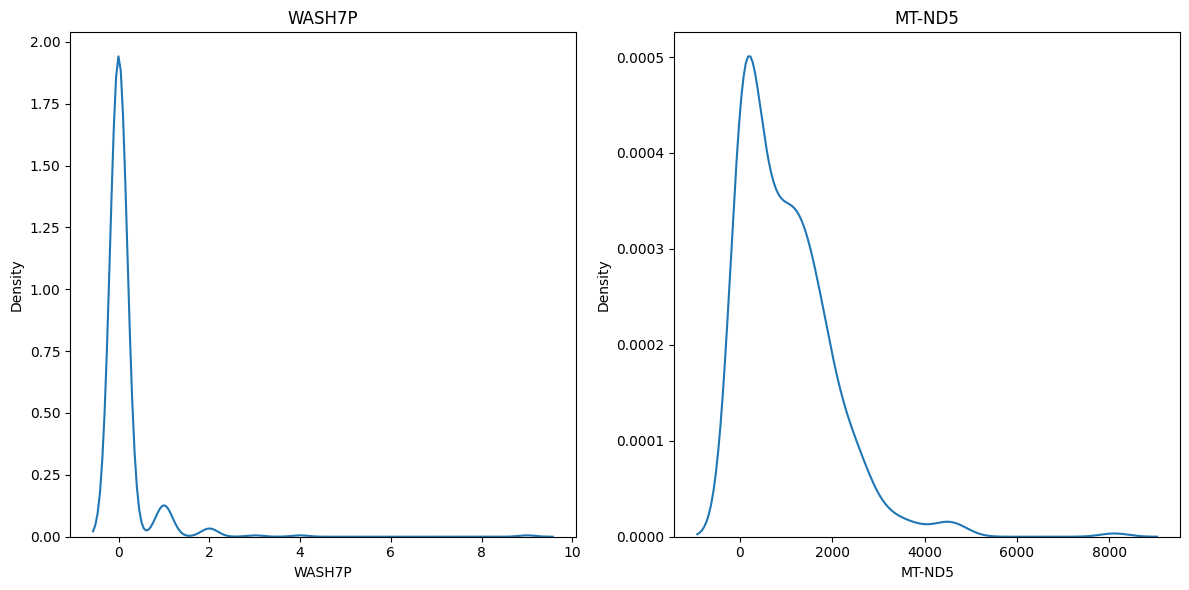

In \[ \]:

    print((unfilt_hcc_smarts.T.describe().loc['mean'] > 1).sum())
    print((unfilt_mcf_smarts.T.describe().loc['mean'] > 1).sum())

    15111
    13745

In \[ \]:

    filt_norm_hcc_drops = pd.read_csv("data/dropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt", sep = " ")
    filt_norm_mcf_drops = pd.read_csv("data/dropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt", sep = " ")
    filt_norm_hcc_smarts = pd.read_csv("data/smartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt", sep = " ")
    filt_norm_mcf_smarts = pd.read_csv("data/smartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt", sep = " ")

In \[ \]:

    print(f"The sparsity in the HCC1806 DropSeq df is: {round((filt_norm_hcc_drops == 0).sum().sum() / (filt_norm_hcc_drops.shape[0] * filt_norm_hcc_drops.shape[1]) * 100, 2)}%")
    print(f"The sparsity in the MCF7 DropSeq df is: {round((filt_norm_mcf_drops == 0).sum().sum() / (filt_norm_mcf_drops.shape[0] * filt_norm_mcf_drops.shape[1]) * 100, 2)}%")
    print(f"The sparsity in the HCC1806 SmartSeq df is: {round((filt_norm_hcc_smarts == 0).sum().sum() / (filt_norm_hcc_smarts.shape[0] * filt_norm_hcc_smarts.shape[1]) * 100, 2)}%")
    print(f"The sparsity in the MCF7 SmartSeq df is: {round((filt_norm_mcf_smarts == 0).sum().sum() / (filt_norm_mcf_smarts.shape[0] * filt_norm_mcf_smarts.shape[1]) * 100, 2)}%")

    The sparsity in the HCC1806 DropSeq df is: 97.64%
    The sparsity in the MCF7 DropSeq df is: 97.53%
    The sparsity in the HCC1806 SmartSeq df is: 70.65%
    The sparsity in the MCF7 SmartSeq df is: 63.62%

It's interesting as it seems that some columns have an average gene
count of 0... we will explore this later and address it.

We now check for null values, which would have to be dealt with in the
circumstance that they were present.

In \[ \]:

    print(f"The number of null values in the hcc1806 dataset are: {unfilt_hcc_smarts.isnull().sum(axis = 1).sum(axis = 0)}")
    print(f"The number of null values in the mcf7 dataset are: {unfilt_mcf_smarts.isnull().sum(axis = 1).sum(axis = 0)}")

    The number of null values in the hcc1806 dataset are: 0
    The number of null values in the mcf7 dataset are: 0

Now let's look at the correlation between cells. It may be useful in
cutting down the overall size of the dataframe and moreover better
understand its structure.

In \[ \]:

    plt.figure(figsize=(12,10))
    plt.title("MCF7 cell correlation heatmap")
    corr = unfilt_mcf_smarts.corr()
    midpoint = (corr.values.max() - corr.values.min()) /2 + corr.values.min()

    sns.heatmap(corr,cmap="coolwarm", center=0, yticklabels=False , xticklabels=False);

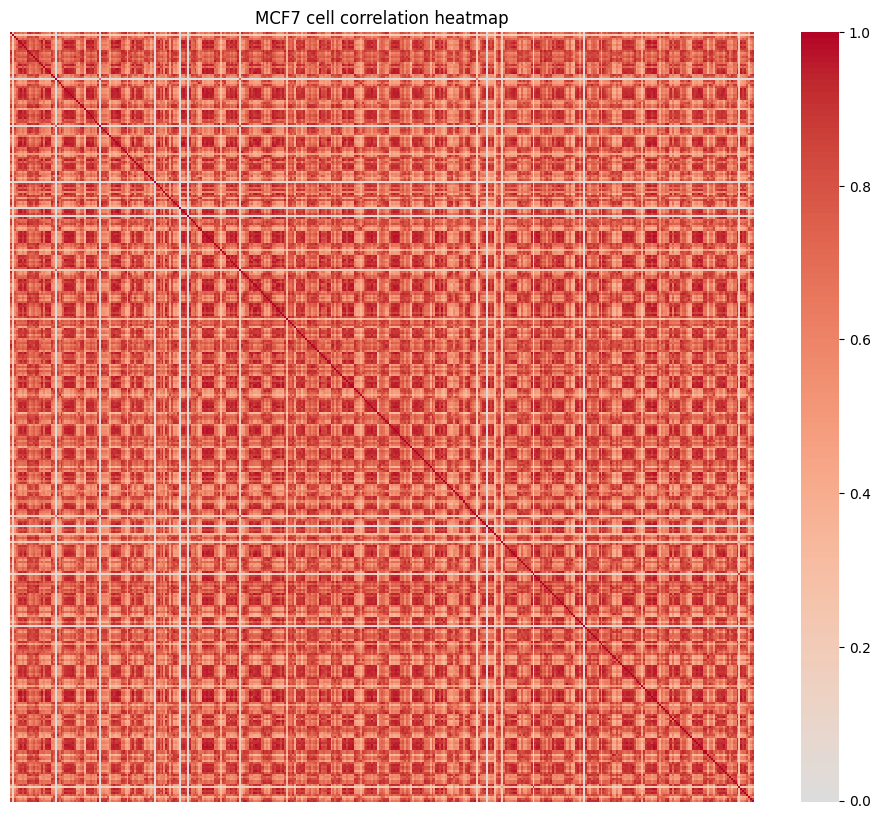

In \[ \]:

    plt.figure(figsize=(12,10))
    plt.title("HCC1806 cell correlation heatmap")
    corr = unfilt_hcc_smarts.corr()
    midpoint = (corr.values.max() - corr.values.min()) /2 + corr.values.min()

    sns.heatmap(corr,cmap="coolwarm", center=0, yticklabels=False , xticklabels=False);

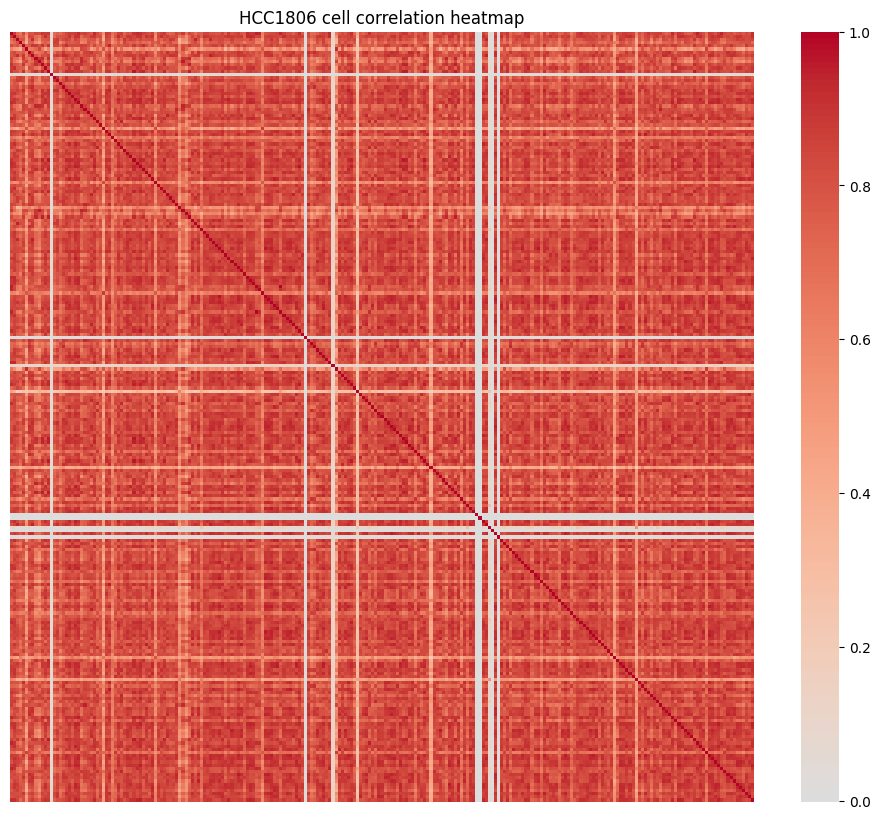

Interestingly there are cells which have a correlation close to 0 with
respect to all other cells (vertical and horizontal white lines), we
will analyse them to try to understand why.

In \[ \]:

    corr = unfilt_mcf_smarts.corr()
    corr_matrix = pd.DataFrame(data=corr)
    corr_matrix.head()

Out\[ \]:

|                                                          | output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam | output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam | output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam | output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam | output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam | output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam | output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam | output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam | output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam | output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam | ... | output.STAR.4_H14_Hypo_S383_Aligned.sortedByCoord.out.bam | output.STAR.4_H1_Norm_S355_Aligned.sortedByCoord.out.bam | output.STAR.4_H2_Norm_S356_Aligned.sortedByCoord.out.bam | output.STAR.4_H3_Norm_S357_Aligned.sortedByCoord.out.bam | output.STAR.4_H4_Norm_S358_Aligned.sortedByCoord.out.bam | output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam | output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam | output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam | output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam | output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam |
|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|---------------------------------------------------------|-----|-----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|
| output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam | 1.000000                                                 | 0.292568                                                 | 0.808329                                                 | 0.697870                                               | 0.721242                                               | 0.642948                                               | 0.709258                                               | 0.617521                                               | 0.618802                                               | 0.900562                                                | ... | 0.838974                                                  | 0.521685                                                 | 0.163054                                                 | 0.560572                                                 | 0.554862                                                 | 0.570941                                                 | 0.668708                                                 | 0.457658                                                 | 0.890291                                                 | 0.874445                                                 |
| output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam | 0.292568                                                 | 1.000000                                                 | 0.146217                                                 | 0.182917                                               | 0.212992                                               | 0.171827                                               | 0.222140                                               | 0.148963                                               | 0.171648                                               | 0.220787                                                | ... | 0.196892                                                  | 0.136905                                                 | 0.116034                                                 | 0.145569                                                 | 0.135938                                                 | 0.110866                                                 | 0.141656                                                 | 0.137021                                                 | 0.254233                                                 | 0.199633                                                 |
| output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam | 0.808329                                                 | 0.146217                                                 | 1.000000                                                 | 0.646251                                               | 0.600347                                               | 0.588118                                               | 0.635104                                               | 0.576847                                               | 0.604278                                               | 0.844294                                                | ... | 0.802609                                                  | 0.540563                                                 | 0.132710                                                 | 0.547429                                                 | 0.576650                                                 | 0.607403                                                 | 0.693280                                                 | 0.609518                                                 | 0.843927                                                 | 0.851434                                                 |
| output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam   | 0.697870                                                 | 0.182917                                                 | 0.646251                                                 | 1.000000                                               | 0.715393                                               | 0.692161                                               | 0.780425                                               | 0.692138                                               | 0.760664                                               | 0.775325                                                | ... | 0.736469                                                  | 0.706532                                                 | 0.346201                                                 | 0.662226                                                 | 0.759793                                                 | 0.689692                                                 | 0.783976                                                 | 0.451558                                                 | 0.667993                                                 | 0.719326                                                 |
| output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam   | 0.721242                                                 | 0.212992                                                 | 0.600347                                                 | 0.715393                                               | 1.000000                                               | 0.955126                                               | 0.895659                                               | 0.943620                                               | 0.869165                                               | 0.838086                                                | ... | 0.679765                                                  | 0.823229                                                 | 0.172095                                                 | 0.902144                                                 | 0.865805                                                 | 0.883352                                                 | 0.698426                                                 | 0.328031                                                 | 0.566170                                                 | 0.667335                                                 |

5 rows × 383 columns

In \[ \]:

    #let's find the cell with the lowest correlation with respect to all other cells and plot its gene structure.
    col_sums = corr_matrix.sum()
    min_col = col_sums.idxmin()
    plt.figure(figsize=(12,10))
    plt.hist(unfilt_mcf_smarts.loc[:,min_col])
    plt.title(f"Gene expression histogram for cell: {min_col}");
    plt.ylabel("Frequency");

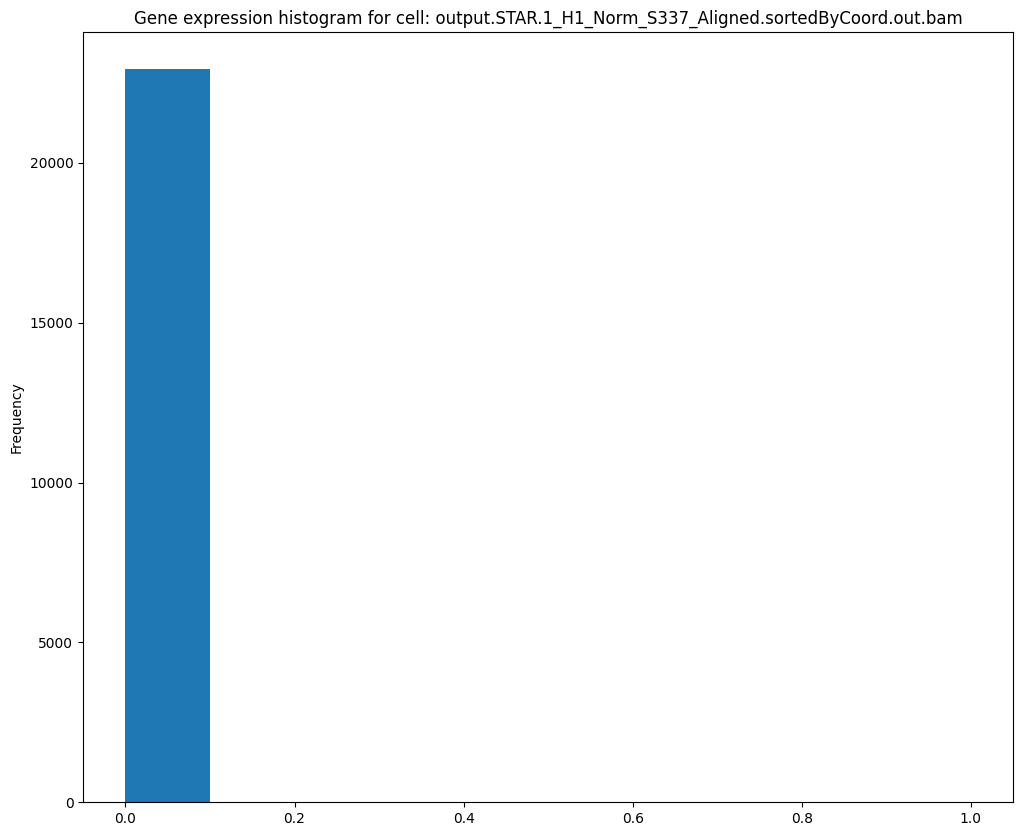

As is evident in the histogram, the reason for why some cells are
totally uncorrelated to others is that they have a gene count of 0 for
all genes (or at least very close to 0 in the other cases). These cells
will be removed during the filtering part.

In this project we will more so focus on genes as opposed to cells, and
therefore understanding the correlations between genes could aid us in
the construction of a model with better accuracy (as well as reducing
redundancy by not including all the covariates which are highly
correlated between each other).

In \[ \]:

    plt.figure(figsize=(16,14))
    plt.title("First 1000 genes correlation for MCF7")
    #df_small = df.iloc[:, :50]
    #c= df_small.corr()
    corr = unfilt_mcf_smarts.iloc[:1000,:].T.corr()
    midpoint = (corr.values.max() - corr.values.min()) /2 + corr.values.min()
    #sns.heatmap(c,cmap='coolwarm',annot=True, center=midpoint )
    sns.heatmap(corr,cmap="YlOrBr", center=0, yticklabels=False , xticklabels=False)

    print("Average correlation between genes: ", midpoint)
    print("Minimum correlation between genes: ", corr.values.min(), "\n")

    Average correlation between genes:  0.3695789318416762
    Minimum correlation between genes:  -0.2608421363166476 

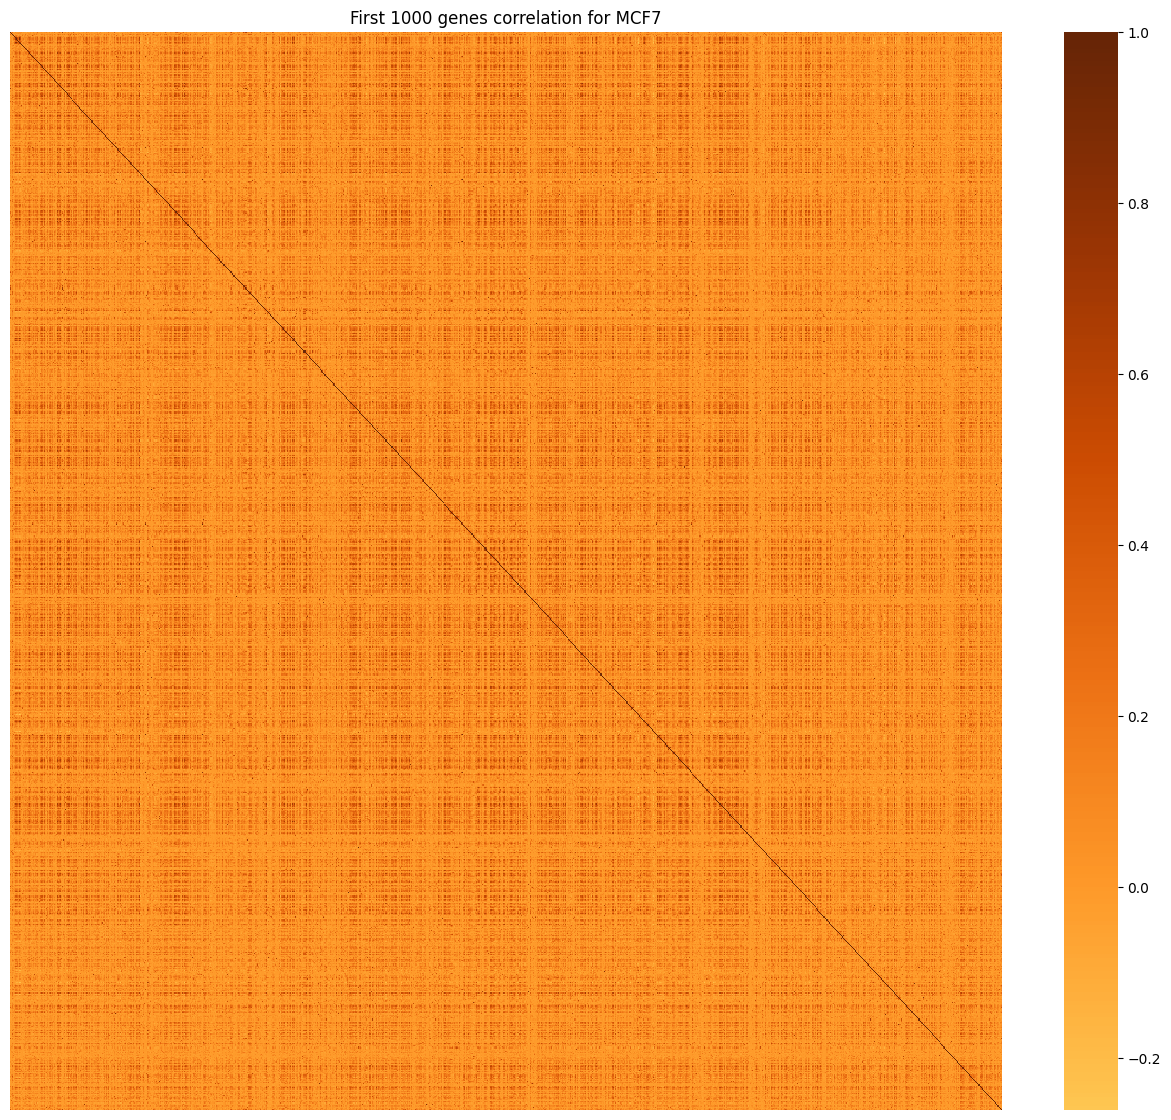

Sadly it seems as though no gene stands out with respect to its
correlation with other genes. This could have been useful as the
presence of highly important genes would have allowed substantial
dimensionality reduction.

Let's now study the distribution of the data to better understand how to
treat it when building our model at the end of the project.

In \[ \]:

    colN = np.shape(unfilt_mcf_smarts)[1]
    colN
    df_skew_cells = []
    for i in range(colN) :     
         v_df = unfilt_mcf_smarts[unfilt_mcf_smarts.columns[i]]
         df_skew_cells += [skew(v_df)]   
      #  df_skew_cells += [df[cnames[i]].skew()]
    df_skew_cells
    sns.histplot(df_skew_cells,bins=100)
    plt.xlabel('Skewness of single cells expression profiles in the mcf7 df')
    plt.show()

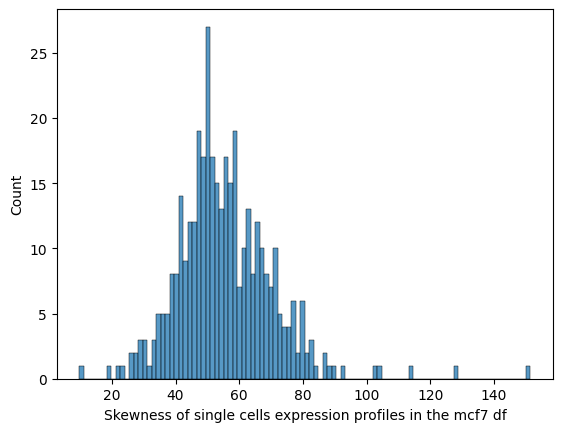

In \[ \]:

    colN = np.shape(unfilt_hcc_smarts)[1]
    colN
    df_skew_cells = []
    for i in range(colN) :     
         v_df = unfilt_hcc_smarts[unfilt_hcc_smarts.columns[i]]
         df_skew_cells += [skew(v_df)]   
      #  df_skew_cells += [df[cnames[i]].skew()]
    df_skew_cells
    sns.histplot(df_skew_cells,bins=100)
    plt.xlabel('Skewness of single cells expression profiles in the hcc1806 df')
    plt.show()

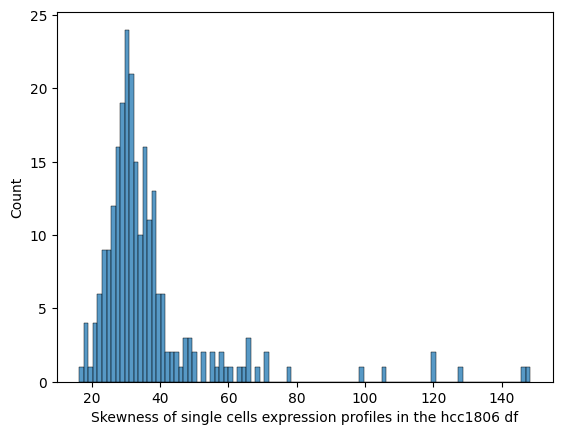

In \[ \]:

    colN = np.shape(unfilt_mcf_smarts)[1]
    colN
    df_skew_cells = []
    for i in range(colN) :     
         v_df = unfilt_mcf_smarts[unfilt_mcf_smarts.columns[i]]
         df_skew_cells += [kurtosis(v_df)]   
      #  df_skew_cells += [df[cnames[i]].skew()]
    df_skew_cells
    sns.histplot(df_skew_cells,bins=100)
    plt.xlabel('Kurtosis of single cells expression profiles in the mcf7 df')
    plt.show()

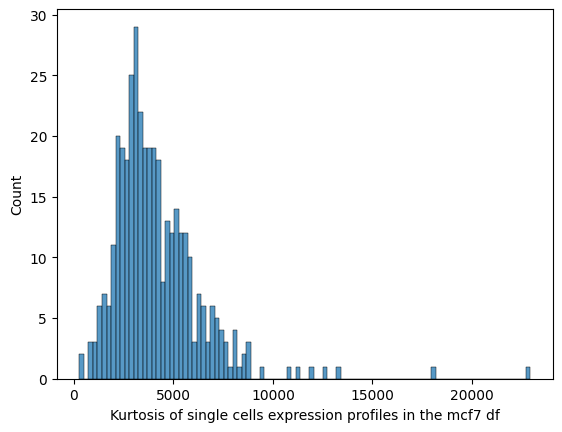

In \[ \]:

    colN = np.shape(unfilt_hcc_smarts)[1]
    colN
    df_skew_cells = []
    for i in range(colN) :     
         v_df = unfilt_hcc_smarts[unfilt_hcc_smarts.columns[i]]
         df_skew_cells += [kurtosis(v_df)]   
      #  df_skew_cells += [df[cnames[i]].skew()]
    df_skew_cells
    sns.histplot(df_skew_cells,bins=100)
    plt.xlabel('Kurtosis of single cells expression profiles in the hcc1806 df')
    plt.show()

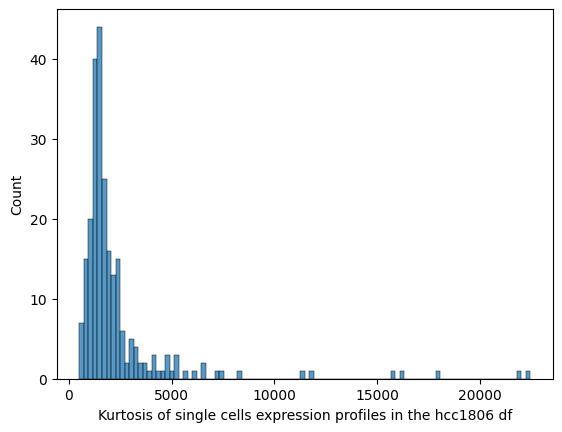

In \[ \]:

    hcc_skew = [skew(unfilt_hcc_smarts[i]) for i in unfilt_hcc_smarts.columns]
    mcf_skew = [skew(unfilt_mcf_smarts[i]) for i in unfilt_mcf_smarts.columns]
    hcc_kurtosis = [kurtosis(unfilt_hcc_smarts[i]) for i in unfilt_hcc_smarts.columns]
    mcf_kurtosis = [kurtosis(unfilt_mcf_smarts[i]) for i in unfilt_mcf_smarts.columns]
    print(f"The mean skewness in the HCC1806 cells is: {np.mean(hcc_skew)}")
    print(f"The mean kurtosis in the HCC1806 cells is: {np.mean(hcc_kurtosis)}")
    print(f"The mean skewness in the MCF7 cells is: {np.mean(mcf_skew)}")
    print(f"The mean kurtosis in the MCF7 cells is: {np.mean(mcf_kurtosis)}")

    The mean skewness in the HCC1806 cells is: 36.75112201656807
    The mean kurtosis in the HCC1806 cells is: 2396.1365186183593
    The mean skewness in the MCF7 cells is: 55.59958034753704
    The mean kurtosis in the MCF7 cells is: 4164.854641341205

The above values of skewness and kurtosis for each dataframe highlight
how the data is highly non-normal, skewed with heavy tails. When coupled
with the fact that most cells have a count of 0 for most genes (but when
they don't they can reach huge counts of 40000+) this suggests that the
information is CONTAINED IN THE OUTLIERS. Therefore, the previous
objective of removing them will be disregarded as it would make the data
obsolete.

This argument can be further strengthened with violin plots.

In \[ \]:

    unfilt_mcf_smarts_small = unfilt_mcf_smarts.iloc[:, :50]
    np.shape(unfilt_mcf_smarts_small)
    plt.figure(figsize=(16,4))
    plot=sns.violinplot(data=unfilt_mcf_smarts_small,palette="Set3",cut=0)
    plt.setp(plot.get_xticklabels(), rotation=90)
    plt.show()

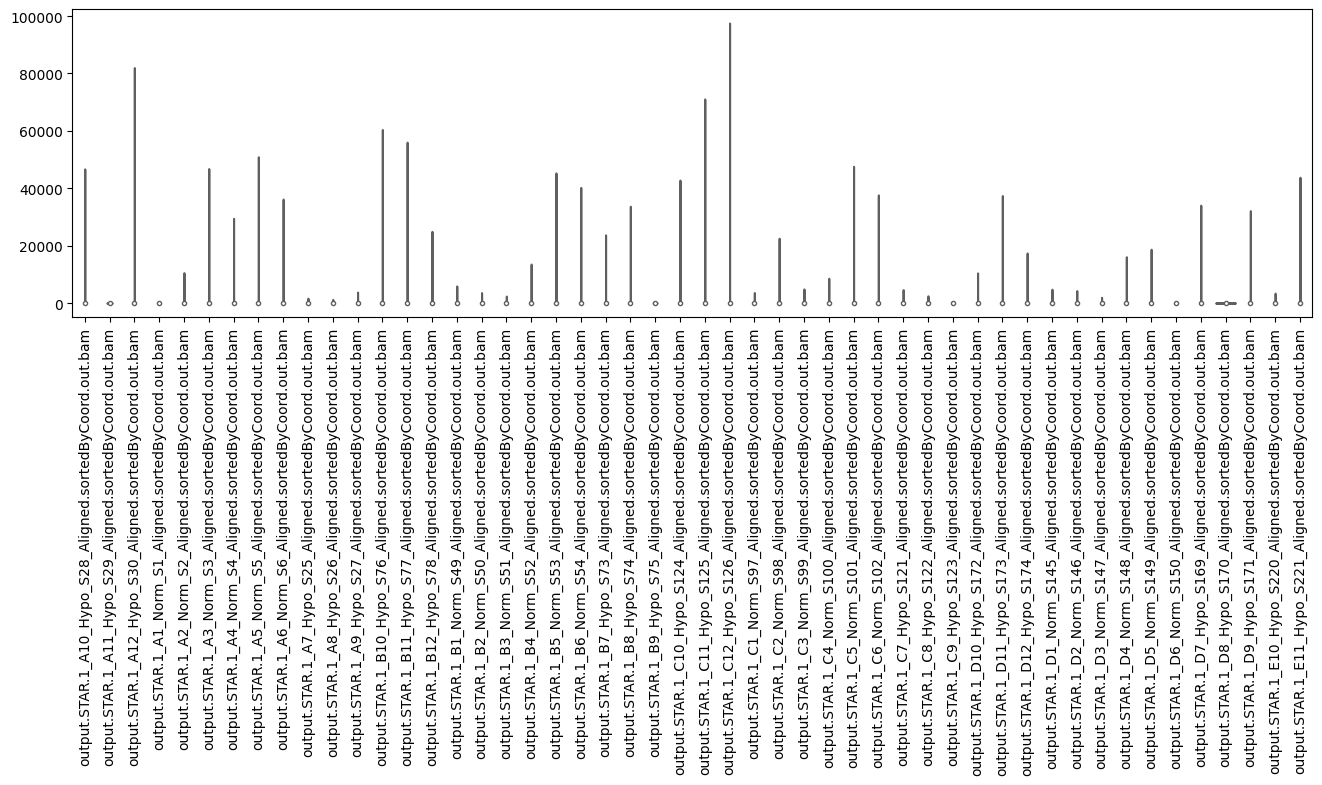

Now let's remove outliers using a standard Interquartile Range approach.

In \[ \]:

    Q1 = unfilt_mcf_smarts.quantile(0.25)
    Q3 = unfilt_mcf_smarts.quantile(0.75)
    IQR = Q3 - Q1
    print(IQR)

    output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam    17.0
    output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam     0.0
    output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam     5.0
    output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam       0.0
    output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam       7.0
                                                                ... 
    output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam     9.0
    output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam    27.0
    output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam    30.0
    output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam    38.0
    output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam    33.0
    Length: 383, dtype: float64

In \[ \]:

    unfilt_mcf_smarts_noOut = unfilt_mcf_smarts[~((unfilt_mcf_smarts < (Q1 - 1.5 * IQR)) |(unfilt_mcf_smarts > (Q3 + 1.5 * IQR))).any(axis=1)]
    print(unfilt_mcf_smarts_noOut.shape)
    unfilt_mcf_smarts_noOut.head(3)

    (6435, 383)

Out\[ \]:

|           | output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam | output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam | output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam | output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam | output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam | output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam | output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam | output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam | output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam | output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam | ... | output.STAR.4_H14_Hypo_S383_Aligned.sortedByCoord.out.bam | output.STAR.4_H1_Norm_S355_Aligned.sortedByCoord.out.bam | output.STAR.4_H2_Norm_S356_Aligned.sortedByCoord.out.bam | output.STAR.4_H3_Norm_S357_Aligned.sortedByCoord.out.bam | output.STAR.4_H4_Norm_S358_Aligned.sortedByCoord.out.bam | output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam | output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam | output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam | output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam | output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam |
|-----------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|---------------------------------------------------------|-----|-----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|----------------------------------------------------------|
| MIR6859-1 | 0                                                        | 0                                                        | 0                                                        | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                       | ... | 0                                                         | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        |
| CICP3     | 0                                                        | 0                                                        | 0                                                        | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                       | ... | 0                                                         | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        |
| FAM87B    | 0                                                        | 0                                                        | 0                                                        | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 0                                                      | 2                                                      | 0                                                       | ... | 0                                                         | 1                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        | 0                                                        |

3 rows × 383 columns

We can see how the above reduced the row size by around 16000 (a 72%
reduction!).

In \[ \]:

    unfilt_mcf_smarts_small_noOut = unfilt_mcf_smarts_noOut.iloc[:, :50]
    np.shape(unfilt_mcf_smarts_small_noOut)
    plt.figure(figsize=(16,4))
    plot=sns.violinplot(data=unfilt_mcf_smarts_small_noOut,palette="Set3",cut=0)
    plt.setp(plot.get_xticklabels(), rotation=90)
    plt.show()

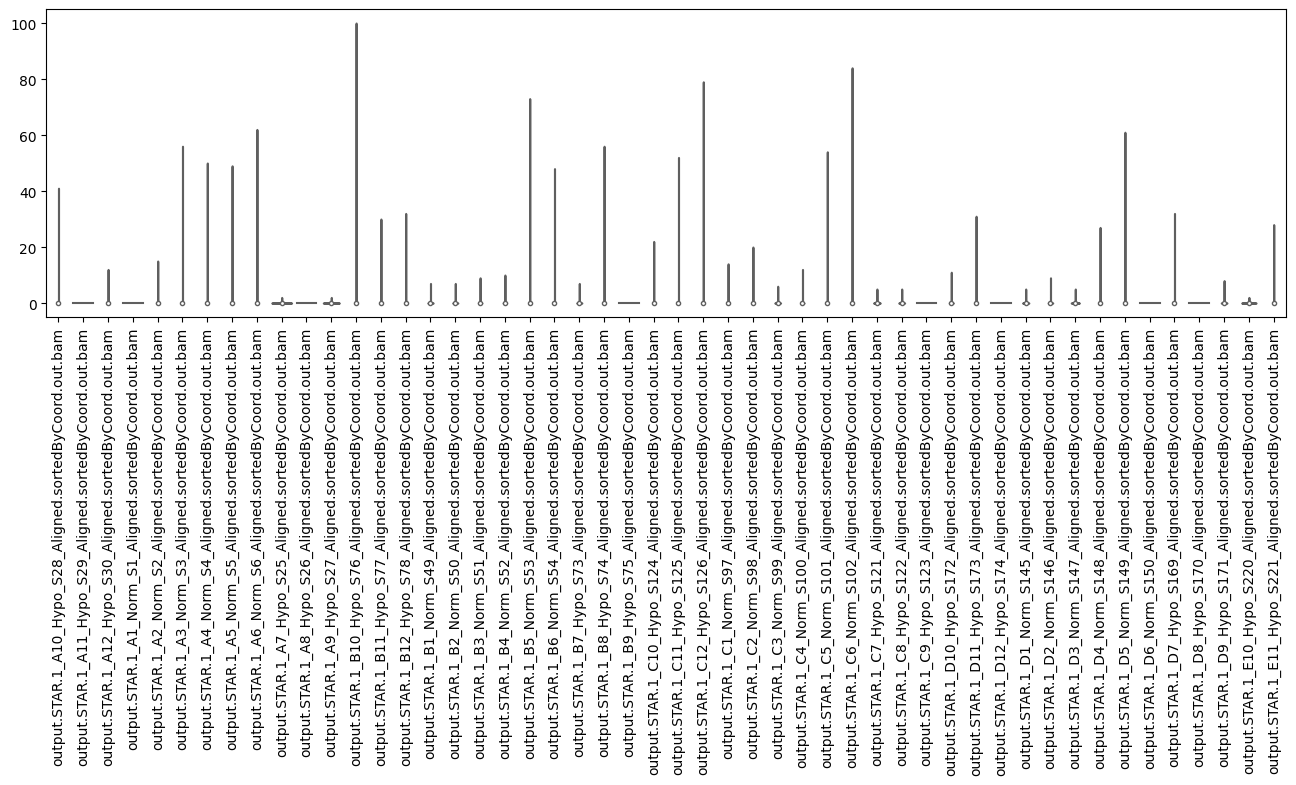

As expected, they still don't look good as we have many zeros now.
Simply removing outliers as expected did not work because the important
information is contained in the non-zero terms. This poses the
question... how sparse is the data?

In \[ \]:

    Q1 = unfilt_hcc_smarts.quantile(0.25)
    Q3 = unfilt_hcc_smarts.quantile(0.75)
    IQR = Q3 - Q1
    unfilt_hcc_smarts_noOut = unfilt_hcc_smarts[~((unfilt_hcc_smarts < (Q1 - 1.5 * IQR)) |(unfilt_hcc_smarts > (Q3 + 1.5 * IQR))).any(axis=1)]

In \[ \]:

    print(f"The sparsity in the HCC1806 df is: {round((unfilt_hcc_smarts == 0).sum().sum() / (unfilt_hcc_smarts.shape[0] * unfilt_hcc_smarts.shape[1]) * 100, 2)}%")
    print(f"The sparsity in the HCC1806 df, without outliers, is: {round((unfilt_hcc_smarts_noOut == 0).sum().sum() / (unfilt_hcc_smarts_noOut.shape[0] * unfilt_hcc_smarts_noOut.shape[1]) * 100, 2)}%")
    print(f"The sparsity in the MCF7 df is: {round((unfilt_mcf_smarts == 0).sum().sum() / (unfilt_mcf_smarts.shape[0] * unfilt_mcf_smarts.shape[1]) * 100, 2)}%")
    print(f"The sparsity in the MCF7 df, without outliers, is: {round((unfilt_mcf_smarts_noOut == 0).sum().sum() / (unfilt_mcf_smarts_noOut.shape[0] * unfilt_mcf_smarts_noOut.shape[1]) * 100, 2)}%")

    The sparsity in the HCC1806 df is: 55.85%
    The sparsity in the HCC1806 df, without outliers, is: 86.73%
    The sparsity in the MCF7 df is: 60.22%
    The sparsity in the MCF7 df, without outliers, is: 95.49%

Evidently this is a very high value of sparsity which again reiterates
our thesis that the important information of the dataset is contained in
the outliers.

Moreover, since we have now understood that the high-zero value cell
lines cannot be disregarded, we may at least attempt to fix the problem
with regardes to the highly non-normal data. In order to do so, we will
attempt using a log2 transformation in the data in the hope that it
renders it more normalised. It is common to utilize log based 2 where +1
denotes a doubling of the feature abundance (in this case, gene
expression) and -1 denotes a halving of the feature abundance/gene
expression. The up-regulation and down-regulation of a gene in relation
to a control are symmetrical when changes in the values are transformed
this way.

In \[ \]:

    hcc_smarts_one = unfilt_hcc_smarts + 1
    hcc_smarts_log = hcc_smarts_one.apply(np.log2)

    mcf_smarts_one = unfilt_mcf_smarts + 1
    mcf_smarts_log = mcf_smarts_one.apply(np.log2)

We now check for kurtosis and skewness again to see how our data
changed.

In \[ \]:

    colN = np.shape(mcf_smarts_log)[1]
    colN
    df_skew_cells = []
    for i in range(colN) :     
         v_df = mcf_smarts_log[mcf_smarts_log.columns[i]]
         df_skew_cells += [skew(v_df)]   
      #  df_skew_cells += [df[cnames[i]].skew()]
    df_skew_cells
    sns.histplot(df_skew_cells,bins=100)
    plt.xlabel('Skewness of single cells expression profiles in the log2 mcf7 df')
    plt.show()

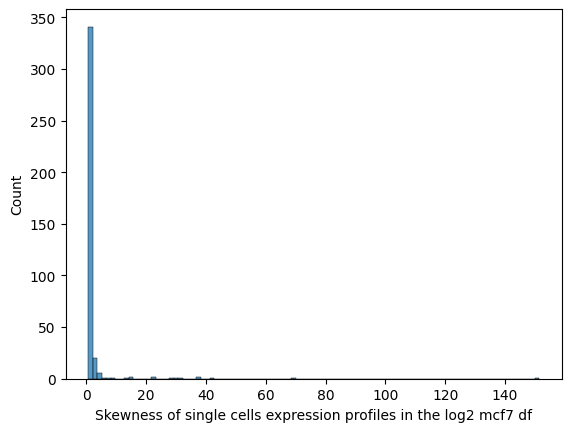

In \[ \]:

    colN = np.shape(hcc_smarts_log)[1]
    colN
    df_skew_cells = []
    for i in range(colN) :     
         v_df = hcc_smarts_log[hcc_smarts_log.columns[i]]
         df_skew_cells += [skew(v_df)]   
      #  df_skew_cells += [df[cnames[i]].skew()]
    df_skew_cells
    sns.histplot(df_skew_cells,bins=100)
    plt.xlabel('Skewness of single cells expression profiles in the log2 hcc1806 df')
    plt.show()

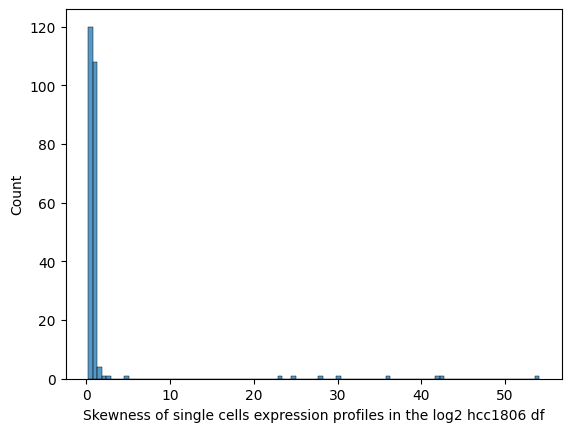

In \[ \]:

    colN = np.shape(mcf_smarts_log)[1]
    colN
    df_skew_cells = []
    for i in range(colN) :     
         v_df = mcf_smarts_log[mcf_smarts_log.columns[i]]
         df_skew_cells += [kurtosis(v_df)]   
      #  df_skew_cells += [df[cnames[i]].skew()]
    df_skew_cells
    sns.histplot(df_skew_cells,bins=100)
    plt.xlabel('Kurtosis of single cells expression profiles in the log2 mcf7 df')
    plt.show()

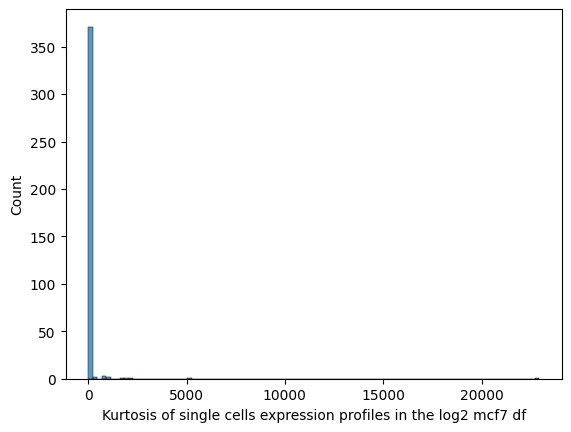

In \[ \]:

    colN = np.shape(hcc_smarts_log)[1]
    colN
    df_skew_cells = []
    for i in range(colN) :     
         v_df = hcc_smarts_log[hcc_smarts_log.columns[i]]
         df_skew_cells += [kurtosis(v_df)]   
      #  df_skew_cells += [df[cnames[i]].skew()]
    df_skew_cells
    sns.histplot(df_skew_cells,bins=100)
    plt.xlabel('Kurtosis of single cells expression profiles in the log2 hcc1806 df')
    plt.show()

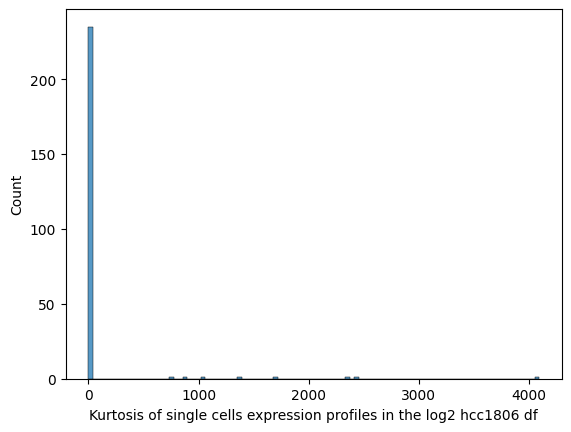

When compared to the above graphs of kurtosis and skewness the data
already looks much better. Let's now use a violinplot, like before, to
see whether this transformation has resulted in an improvement or not.

In \[ \]:

    mcf_smarts_log_small = mcf_smarts_log.iloc[:, :50]
    np.shape(mcf_smarts_log_small)
    plt.figure(figsize=(16,4))
    plot=sns.violinplot(data=mcf_smarts_log_small,palette="Set3",cut=0)
    plt.setp(plot.get_xticklabels(), rotation=90)
    plt.show()

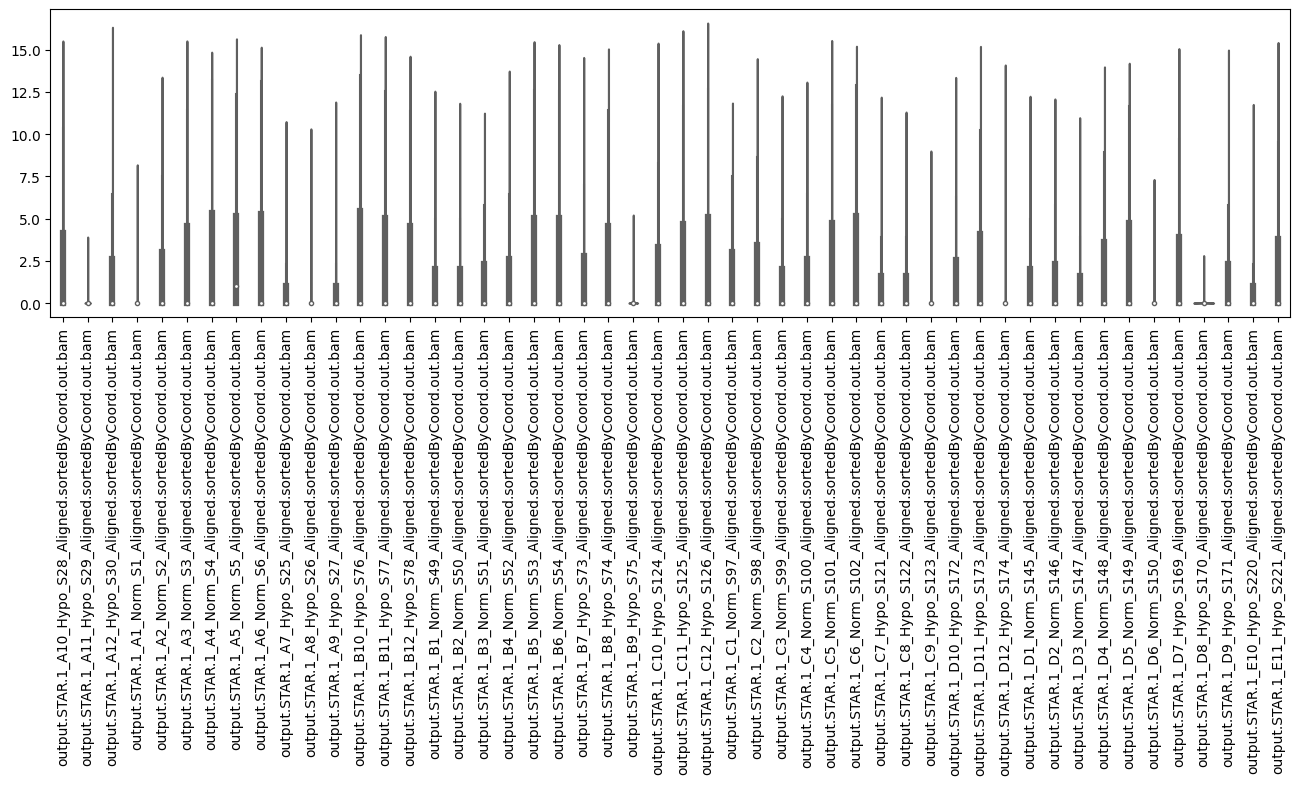

As expected, the transformation has indeed helped us as shown by our
violin plots (this is especially visible when compared to the previous
version of them).

Finally before continuing, let's check for and remove duplicate rows in
each dataframe... this could be the result of various reasons such as
but not limited to redundancy in gene annotation, overlapping of gene
annotation on the same region etc.

In \[ \]:

    hcc_dup_unfilt = hcc_smarts_log[hcc_smarts_log.duplicated(keep=False)]
    print(f"The number of duplicate rows in the HCC1806 dataframe is: {hcc_dup_unfilt.shape[0]}")
    mcf_dup_unfilt = mcf_smarts_log[mcf_smarts_log.duplicated(keep=False)]
    print(f"The number of duplicate rows in the MCF7 dataframe is: {mcf_dup_unfilt.shape[0]}")

    The number of duplicate rows in the HCC1806 dataframe is: 89
    The number of duplicate rows in the MCF7 dataframe is: 56

It is important to keep track of the genes which we will remove during
this step, as duplicates, and we may do so consulting the correlation
matrix and connecting genes with perfect correlation with each other in
a dictionary.

In \[ \]:

    hcc_dup_corr = hcc_dup_unfilt.T.corr()
    mcf_dup_corr = mcf_dup_unfilt.T.corr()

    hcc_duplicates_dict = dict()
    for col in hcc_dup_corr.columns:
        for row in hcc_dup_corr.index:
            if (hcc_dup_corr.loc[row, col] == 1 and row != col):
                if row not in hcc_duplicates_dict:
                   hcc_duplicates_dict[row] = []
                hcc_duplicates_dict[row].append(col)
                   

    mcf_duplicates_dict = dict()
    for col in mcf_dup_corr.columns:
        for row in mcf_dup_corr.index:
            if (mcf_dup_corr.loc[row, col] == 1 and row != col):
                if row not in mcf_duplicates_dict:
                   mcf_duplicates_dict[row] = []
                mcf_duplicates_dict[row].append(col)

    print("This dictionary stores the genes of correlation 1 together")          
    hcc_duplicates_dict

    This dictionary stores the genes of correlation 1 together

Out\[ \]:

    {'RPL21P66': ['MMP23A'],
     'CNPY1': ['LINC01647'],
     'ITGA10': ['LINC01361',
      'GPA33',
      'C4orf50',
      'SMIM23',
      'VNN3',
      'TRPV6',
      'KCNA4',
      'APLNR',
      'CYCSP26',
      'OR5AU1',
      'CD300A',
      'DTNA',
      'PLVAP'],
     'GPA33': ['LINC01361',
      'ITGA10',
      'C4orf50',
      'SMIM23',
      'VNN3',
      'TRPV6',
      'KCNA4',
      'APLNR',
      'CYCSP26',
      'OR5AU1',
      'CD300A',
      'DTNA',
      'PLVAP'],
     'C4orf50': ['LINC01361',
      'ITGA10',
      'GPA33',
      'SMIM23',
      'VNN3',
      'TRPV6',
      'KCNA4',
      'APLNR',
      'CYCSP26',
      'OR5AU1',
      'CD300A',
      'DTNA',
      'PLVAP'],
     'SMIM23': ['LINC01361',
      'ITGA10',
      'GPA33',
      'C4orf50',
      'VNN3',
      'TRPV6',
      'KCNA4',
      'APLNR',
      'CYCSP26',
      'OR5AU1',
      'CD300A',
      'DTNA',
      'PLVAP'],
     'VNN3': ['LINC01361',
      'ITGA10',
      'GPA33',
      'C4orf50',
      'SMIM23',
      'TRPV6',
      'KCNA4',
      'APLNR',
      'CYCSP26',
      'OR5AU1',
      'CD300A',
      'DTNA',
      'PLVAP'],
     'TRPV6': ['LINC01361',
      'ITGA10',
      'GPA33',
      'C4orf50',
      'SMIM23',
      'VNN3',
      'KCNA4',
      'APLNR',
      'CYCSP26',
      'OR5AU1',
      'CD300A',
      'DTNA',
      'PLVAP'],
     'KCNA4': ['LINC01361',
      'ITGA10',
      'GPA33',
      'C4orf50',
      'SMIM23',
      'VNN3',
      'TRPV6',
      'APLNR',
      'CYCSP26',
      'OR5AU1',
      'CD300A',
      'DTNA',
      'PLVAP'],
     'APLNR': ['LINC01361',
      'ITGA10',
      'GPA33',
      'C4orf50',
      'SMIM23',
      'VNN3',
      'TRPV6',
      'KCNA4',
      'CYCSP26',
      'OR5AU1',
      'CD300A',
      'DTNA',
      'PLVAP'],
     'CYCSP26': ['LINC01361',
      'ITGA10',
      'GPA33',
      'C4orf50',
      'SMIM23',
      'VNN3',
      'TRPV6',
      'KCNA4',
      'APLNR',
      'OR5AU1',
      'CD300A',
      'DTNA',
      'PLVAP'],
     'OR5AU1': ['LINC01361',
      'ITGA10',
      'GPA33',
      'C4orf50',
      'SMIM23',
      'VNN3',
      'TRPV6',
      'KCNA4',
      'APLNR',
      'CYCSP26',
      'CD300A',
      'DTNA',
      'PLVAP'],
     'CD300A': ['LINC01361',
      'ITGA10',
      'GPA33',
      'C4orf50',
      'SMIM23',
      'VNN3',
      'TRPV6',
      'KCNA4',
      'APLNR',
      'CYCSP26',
      'OR5AU1',
      'DTNA',
      'PLVAP'],
     'DTNA': ['LINC01361',
      'ITGA10',
      'GPA33',
      'C4orf50',
      'SMIM23',
      'VNN3',
      'TRPV6',
      'KCNA4',
      'APLNR',
      'CYCSP26',
      'OR5AU1',
      'CD300A',
      'PLVAP'],
     'PLVAP': ['LINC01361',
      'ITGA10',
      'GPA33',
      'C4orf50',
      'SMIM23',
      'VNN3',
      'TRPV6',
      'KCNA4',
      'APLNR',
      'CYCSP26',
      'OR5AU1',
      'CD300A',
      'DTNA'],
     'LINC01361': ['ITGA10',
      'GPA33',
      'C4orf50',
      'SMIM23',
      'VNN3',
      'TRPV6',
      'KCNA4',
      'APLNR',
      'CYCSP26',
      'OR5AU1',
      'CD300A',
      'DTNA',
      'PLVAP'],
     'OR2M4': ['RORC'],
     'RORC': ['OR2M4'],
     'CUX2': ['LINC01247'],
     'RNU6-826P': ['SNORD92'],
     'ZBTB45P2': ['LINC01106'],
     'LINC01106': ['ZBTB45P2'],
     'RNY1P12': ['AOX3P'],
     'B3GAT1-DT': ['CPS1', 'COL2A1'],
     'COL2A1': ['CPS1', 'B3GAT1-DT'],
     'SOX5': ['RPS3AP53'],
     'KCNJ16': ['CCR4'],
     'AOX3P': ['RNY1P12'],
     'ALPK2': ['C4orf45'],
     'PCDHA8': ['PCDHA2'],
     'PCDHA2': ['PCDHA8'],
     'PCDHGA3': ['PCDHGA2',
      'PCDHGB3',
      'PCDHGA7',
      'PCDHGA9',
      'PCDHGB7',
      'PCDHGA12',
      'PCDHGC4'],
     'PCDHGB3': ['PCDHGA2',
      'PCDHGA3',
      'PCDHGA7',
      'PCDHGA9',
      'PCDHGB7',
      'PCDHGA12',
      'PCDHGC4'],
     'PCDHGA7': ['PCDHGA2',
      'PCDHGA3',
      'PCDHGB3',
      'PCDHGA9',
      'PCDHGB7',
      'PCDHGA12',
      'PCDHGC4'],
     'PCDHGA9': ['PCDHGA2',
      'PCDHGA3',
      'PCDHGB3',
      'PCDHGA7',
      'PCDHGB7',
      'PCDHGA12',
      'PCDHGC4'],
     'PCDHGB7': ['PCDHGA2',
      'PCDHGA3',
      'PCDHGB3',
      'PCDHGA7',
      'PCDHGA9',
      'PCDHGA12',
      'PCDHGC4'],
     'PCDHGA12': ['PCDHGA2',
      'PCDHGA3',
      'PCDHGB3',
      'PCDHGA7',
      'PCDHGA9',
      'PCDHGB7',
      'PCDHGC4'],
     'PCDHGC4': ['PCDHGA2',
      'PCDHGA3',
      'PCDHGB3',
      'PCDHGA7',
      'PCDHGA9',
      'PCDHGB7',
      'PCDHGA12'],
     'PCDHGA2': ['PCDHGA3',
      'PCDHGB3',
      'PCDHGA7',
      'PCDHGA9',
      'PCDHGB7',
      'PCDHGA12',
      'PCDHGC4'],
     'PAX2': ['PCDHGB9P'],
     'LAP3P2': ['PANDAR'],
     'PANDAR': ['LAP3P2'],
     'RASL12': ['RBBP4P3'],
     'MMP23A': ['RPL21P66'],
     'LINC01647': ['CNPY1'],
     'RPL10AP3': ['ASS1P4'],
     'LINC02833': ['SLC7A3'],
     'MIR374C': ['MIR374B'],
     'MIR374B': ['MIR374C'],
     'RPL22P18': ['NAB1P1'],
     'ASS1P4': ['RPL10AP3'],
     'MIR548D1': ['MIR548AA1'],
     'MIR548AA1': ['MIR548D1'],
     'FBLIM1P2': ['SCARNA8'],
     'MIR24-1': ['MIR3074'],
     'MIR3074': ['MIR24-1'],
     'STRA6LP': ['SUGT1P4-STRA6LP'],
     'SUGT1P4-STRA6LP': ['STRA6LP'],
     'SCARNA8': ['FBLIM1P2'],
     'LINC02395': ['OPCML'],
     'CPS1': ['B3GAT1-DT', 'COL2A1'],
     'CILP': ['RPL21P88'],
     'OR7G2': ['LINC02625'],
     'NAB1P1': ['RPL22P18'],
     'PCDHGB9P': ['PAX2'],
     'RPS3AP53': ['SOX5'],
     'OPCML': ['LINC02395'],
     'ENPP7': ['LDHAL6CP'],
     'LINC01247': ['CUX2'],
     'NUS1P2': ['LINC00621'],
     'LINC00621': ['NUS1P2'],
     'MIR6864': ['UBBP5'],
     'SLC7A3': ['LINC02833'],
     'RBBP4P3': ['RASL12'],
     'RPL21P88': ['CILP'],
     'UBBP5': ['MIR6864'],
     'MIR4520-2': ['MIR4520-1'],
     'MIR4520-1': ['MIR4520-2'],
     'CCL3L1': ['CCL3L3'],
     'CCL3L3': ['CCL3L1'],
     'SNORD92': ['RNU6-826P'],
     'MSX2P1': ['OR4D1'],
     'OR4D1': ['MSX2P1'],
     'MIR548AA2': ['MIR548D2'],
     'MIR548D2': ['MIR548AA2'],
     'CCR4': ['KCNJ16'],
     'LDHAL6CP': ['ENPP7'],
     'C4orf45': ['ALPK2'],
     'LINC02625': ['OR7G2']}

In \[ \]:

    mcf_smarts_log = mcf_smarts_log.copy().drop_duplicates()
    hcc_smarts_log = hcc_smarts_log.copy().drop_duplicates()

Having filtered the dataframe as such we can ensure a more expressive
form of the data without redundancy which may help us in the remainder
of the project when implementing models.

## Dimensionality Reduction<a href="#Dimensionality-Reduction" class="anchor-link">¶</a>

We will start by plotting a 2-components PCA for both dataframes as it
could give us important information regarding the characteristics of the
dataset, which could then be used in the implementation of the models.
Nonetheless, before continuing we will transform the dataset by
transposing it as to get the features (genes) as columns. We will use an
auxiliary function *add_label_T* which transposes the matrix and adds
the label category (0 - Hypoxia, 1 - Normoxia)

In \[ \]:

    hcc_smarts_df = add_label_T(hcc_smarts_log)
    mcf_smarts_df = add_label_T(mcf_smarts_log)

    X1 = hcc_smarts_df.loc[:,hcc_smarts_df.columns!='label']
    X2 = mcf_smarts_df.loc[:,mcf_smarts_df.columns!='label']
    y_hcc = hcc_smarts_df['label']
    y_mcf = mcf_smarts_df['label']
    display(X1)
    display(X2)

|                                                                      | WASH7P | CICP27 | DDX11L17 | WASH9P | OR4F29   | MTND1P23 | MTND2P28 | MTCO1P12  | MTCO2P12 | MTATP8P1 | ... | MT-TH    | MT-TS2   | MT-TL2   | MT-ND5    | MT-ND6    | MT-TE    | MT-CYB    | MT-TT    | MT-TP    | MAFIP    |
|----------------------------------------------------------------------|--------|--------|----------|--------|----------|----------|----------|-----------|----------|----------|-----|----------|----------|----------|-----------|-----------|----------|-----------|----------|----------|----------|
| output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam | 0.0    | 0.0    | 0.0      | 0.0    | 1.584963 | 7.971544 | 5.781360 | 10.765700 | 2.807355 | 1.0      | ... | 4.169925 | 2.584963 | 4.000000 | 11.911766 | 9.815383  | 4.523562 | 12.039262 | 4.754888 | 6.066089 | 0.000000 |
| output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam  | 0.0    | 0.0    | 0.0      | 0.0    | 0.000000 | 8.731319 | 6.658211 | 11.192909 | 2.584963 | 1.0      | ... | 5.643856 | 4.906891 | 5.209453 | 12.864573 | 10.491853 | 5.459432 | 12.664447 | 5.977280 | 6.169925 | 2.321928 |
| output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam    | 0.0    | 0.0    | 0.0      | 0.0    | 0.000000 | 3.584963 | 0.000000 | 4.523562  | 0.000000 | 0.0      | ... | 0.000000 | 0.000000 | 0.000000 | 6.554589  | 3.700440  | 0.000000 | 4.700440  | 0.000000 | 1.000000 | 0.000000 |
| output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam   | 0.0    | 0.0    | 0.0      | 0.0    | 0.000000 | 6.000000 | 4.087463 | 9.995767  | 2.000000 | 0.0      | ... | 5.459432 | 4.169925 | 3.169925 | 10.531381 | 7.876517  | 0.000000 | 12.234817 | 3.584963 | 2.000000 | 3.000000 |
| output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam     | 0.0    | 0.0    | 0.0      | 0.0    | 0.000000 | 4.807355 | 2.000000 | 8.247928  | 0.000000 | 0.0      | ... | 0.000000 | 0.000000 | 2.000000 | 8.247928  | 5.087463  | 0.000000 | 8.280771  | 2.321928 | 3.321928 | 0.000000 |
| ...                                                                  | ...    | ...    | ...      | ...    | ...      | ...      | ...      | ...       | ...      | ...      | ... | ...      | ...      | ...      | ...       | ...       | ...      | ...       | ...      | ...      | ...      |
| output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam | 0.0    | 0.0    | 0.0      | 1.0    | 0.000000 | 7.199672 | 5.584963 | 9.909893  | 1.000000 | 0.0      | ... | 4.700440 | 4.169925 | 3.584963 | 11.515207 | 8.727920  | 4.754888 | 11.861087 | 5.426265 | 5.614710 | 2.000000 |
| output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam | 0.0    | 0.0    | 0.0      | 0.0    | 0.000000 | 5.247928 | 2.807355 | 8.543032  | 0.000000 | 0.0      | ... | 1.584963 | 1.000000 | 2.000000 | 9.428360  | 6.845490  | 1.000000 | 9.943980  | 1.000000 | 4.247928 | 0.000000 |
| output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam   | 0.0    | 0.0    | 0.0      | 1.0    | 0.000000 | 6.392317 | 4.954196 | 10.140830 | 2.321928 | 0.0      | ... | 3.321928 | 2.807355 | 4.584963 | 11.550747 | 8.927778  | 2.321928 | 11.140191 | 4.000000 | 5.209453 | 1.584963 |
| output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam  | 0.0    | 0.0    | 0.0      | 0.0    | 0.000000 | 5.584963 | 3.000000 | 8.016808  | 1.000000 | 0.0      | ... | 1.584963 | 2.000000 | 2.000000 | 9.257388  | 6.247928  | 2.321928 | 9.939579  | 2.807355 | 3.169925 | 1.000000 |
| output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam  | 0.0    | 0.0    | 0.0      | 0.0    | 0.000000 | 7.965784 | 5.285402 | 9.938109  | 0.000000 | 0.0      | ... | 3.906891 | 2.000000 | 4.000000 | 11.265029 | 9.005625  | 4.392317 | 10.994353 | 5.129283 | 6.321928 | 2.584963 |

243 rows × 23342 columns

|                                                          | WASH7P | MIR6859-1 | WASH9P   | OR4F29 | MTND1P23 | MTND2P28 | MTCO1P12 | MTCO2P12 | MTATP8P1 | MTATP6P1 | ... | MT-TH    | MT-TS2   | MT-TL2   | MT-ND5    | MT-ND6   | MT-TE    | MT-CYB    | MT-TT    | MT-TP    | MAFIP    |
|----------------------------------------------------------|--------|-----------|----------|--------|----------|----------|----------|----------|----------|----------|-----|----------|----------|----------|-----------|----------|----------|-----------|----------|----------|----------|
| output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam | 0.0    | 0.0       | 1.000000 | 0.0    | 0.0      | 1.584963 | 1.584963 | 0.000000 | 0.0      | 4.906891 | ... | 0.000000 | 0.000000 | 0.000000 | 8.982994  | 7.209453 | 2.321928 | 8.082149  | 0.000000 | 2.584963 | 3.169925 |
| output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam | 0.0    | 0.0       | 0.000000 | 0.0    | 0.0      | 0.000000 | 0.000000 | 0.000000 | 0.0      | 0.000000 | ... | 1.000000 | 1.000000 | 0.000000 | 1.000000  | 0.000000 | 0.000000 | 1.000000  | 0.000000 | 0.000000 | 0.000000 |
| output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam | 0.0    | 0.0       | 0.000000 | 0.0    | 0.0      | 1.000000 | 1.000000 | 1.000000 | 0.0      | 3.700440 | ... | 0.000000 | 0.000000 | 0.000000 | 1.000000  | 0.000000 | 0.000000 | 6.266787  | 0.000000 | 0.000000 | 0.000000 |
| output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam   | 0.0    | 0.0       | 0.000000 | 0.0    | 0.0      | 0.000000 | 0.000000 | 0.000000 | 0.0      | 3.000000 | ... | 1.000000 | 0.000000 | 0.000000 | 5.491853  | 3.169925 | 0.000000 | 6.066089  | 0.000000 | 1.000000 | 0.000000 |
| output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam   | 0.0    | 0.0       | 0.000000 | 0.0    | 0.0      | 0.000000 | 0.000000 | 0.000000 | 0.0      | 6.108524 | ... | 0.000000 | 0.000000 | 0.000000 | 7.894818  | 5.000000 | 2.000000 | 9.507795  | 0.000000 | 0.000000 | 0.000000 |
| ...                                                      | ...    | ...       | ...      | ...    | ...      | ...      | ...      | ...      | ...      | ...      | ... | ...      | ...      | ...      | ...       | ...      | ...      | ...       | ...      | ...      | ...      |
| output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam | 0.0    | 0.0       | 0.000000 | 0.0    | 0.0      | 0.000000 | 1.000000 | 0.000000 | 0.0      | 5.643856 | ... | 0.000000 | 0.000000 | 1.000000 | 8.417853  | 5.554589 | 1.000000 | 9.157347  | 0.000000 | 0.000000 | 0.000000 |
| output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam | 0.0    | 0.0       | 1.000000 | 0.0    | 0.0      | 1.584963 | 2.584963 | 2.584963 | 0.0      | 8.535275 | ... | 0.000000 | 0.000000 | 1.584963 | 10.655531 | 7.754888 | 2.807355 | 11.764042 | 2.000000 | 3.000000 | 2.807355 |
| output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam | 1.0    | 0.0       | 1.000000 | 0.0    | 0.0      | 3.000000 | 0.000000 | 0.000000 | 0.0      | 5.087463 | ... | 0.000000 | 0.000000 | 0.000000 | 5.977280  | 4.392317 | 0.000000 | 8.451211  | 0.000000 | 1.584963 | 0.000000 |
| output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam | 0.0    | 0.0       | 2.321928 | 1.0    | 0.0      | 4.906891 | 2.321928 | 0.000000 | 0.0      | 7.839204 | ... | 2.000000 | 0.000000 | 1.584963 | 10.918118 | 9.169925 | 3.000000 | 11.093418 | 1.584963 | 4.857981 | 1.000000 |
| output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam | 1.0    | 0.0       | 2.584963 | 0.0    | 0.0      | 2.584963 | 2.000000 | 0.000000 | 0.0      | 6.169925 | ... | 2.584963 | 1.584963 | 2.000000 | 10.376125 | 8.939579 | 2.321928 | 10.167418 | 1.584963 | 3.584963 | 2.321928 |

383 rows × 22905 columns

### HCC1806<a href="#HCC1806" class="anchor-link">¶</a>

#### PCA<a href="#PCA" class="anchor-link">¶</a>

In \[ \]:

    #Running PCA on the hcc dataframe
    pca = PCA(n_components=2)
    pca.fit(X1)

    print(f"The 2-component explained variance is divided as follows: {pca.explained_variance_ratio_}")
    print(f"It accounts for a total of: {round(sum(pca.explained_variance_ratio_)*100,2)}% of the total variance")
    red_X1 = pd.DataFrame(pca.transform(X1))
    display(red_X1)

    The 2-component explained variance is divided as follows: [0.26704041 0.02667803]
    It accounts for a total of: 29.37% of the total variance

|     | 0           | 1          |
|-----|-------------|------------|
| 0   | -48.394513  | 51.352699  |
| 1   | -162.807133 | 19.187212  |
| 2   | 233.481229  | -42.044578 |
| 3   | 24.065042   | 75.115548  |
| 4   | 71.280007   | -31.008899 |
| ... | ...         | ...        |
| 238 | -122.856096 | -66.739536 |
| 239 | 48.115327   | -55.771344 |
| 240 | -76.267669  | -17.407653 |
| 241 | 51.282363   | -20.157439 |
| 242 | -56.979308  | -8.071117  |

243 rows × 2 columns

In \[ \]:

    plt.figure(figsize=(4, 4))
    plt.scatter(red_X1[0], red_X1[1], alpha=0.4, c=y_hcc)
    plt.title("2-component PCA for HCC1806")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

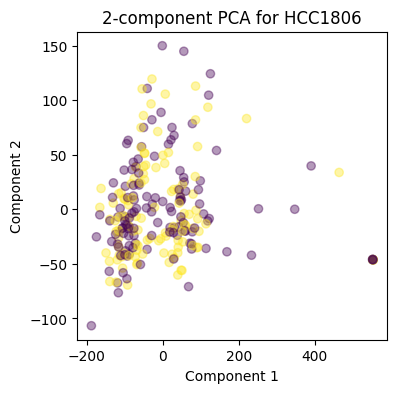

We can unfortunately not see separability between the two components
which could have be useful when developing models which make use of it
(such as, but not limited to, SVMs).

#### Multidimensional Scaling (MDS)<a href="#Multidimensional-Scaling-(MDS)" class="anchor-link">¶</a>

reduces dimensionality while trying to preserve the distances between
the instances.

In \[ \]:

    mds = MDS(n_components=2, random_state=42, normalized_stress='auto')
    X1_reduced_mds = mds.fit_transform(X1)

In \[ \]:

    plt.figure(figsize=(4, 4))
    plt.scatter(X1_reduced_mds[:, 0], X1_reduced_mds[:, 1], alpha=0.4, c=y_hcc)
    plt.title("2-component MDS for HCC1806")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

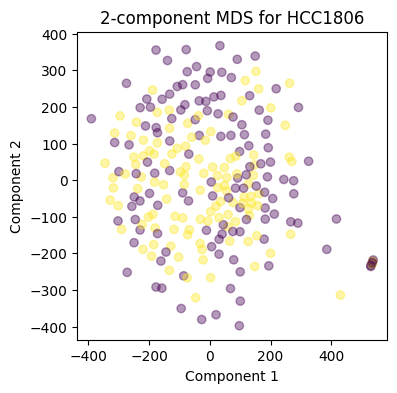

#### Isomap<a href="#Isomap" class="anchor-link">¶</a>

creates a graph by connecting each instance to its nearest neighbors,
then reduces dimensionality while trying to preserve the geodesic
distances between the instances.

In \[ \]:

    isomap = Isomap(n_components=2)
    X1_reduced_isomap = isomap.fit_transform(X1)

In \[ \]:

    plt.figure(figsize=(4, 4))
    plt.scatter(X1_reduced_isomap[:, 0], X1_reduced_isomap[:, 1], alpha=0.4, c=y_hcc)
    plt.title("2-component Isomap for HCC1806")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

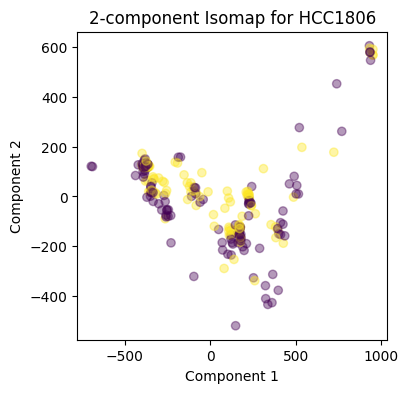

#### t-Distributed Stochastic Neighbor Embedding (t-SNE)<a href="#t-Distributed-Stochastic-Neighbor-Embedding-(t-SNE)"
class="anchor-link">¶</a>

reduces dimensionality while trying to keep similar instances close and
dissimilar instances apart. It is mostly used for visualization, in
particular to visualize clusters of instances in high-dimensional space
(e.g., to visualize the MNIST images in 2D).

In \[ \]:

    tsne = TSNE(n_components=2, init="random", learning_rate="auto",
                random_state=42)
    X1_reduced_tsne = tsne.fit_transform(X1)

In \[ \]:

    plt.figure(figsize=(4, 4))
    plt.scatter(X1_reduced_tsne[:, 0], X1_reduced_tsne[:, 1], alpha=0.4, c=y_hcc)
    plt.title("2-component t-SNE for HCC1806")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

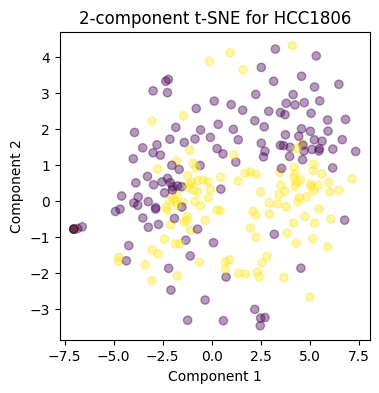

### MCF7<a href="#MCF7" class="anchor-link">¶</a>

#### PCA<a href="#PCA" class="anchor-link">¶</a>

In \[ \]:

    #Running PCA on the mcf dataframe
    pca = PCA(n_components=2)
    pca.fit(X2)

    print(f"The 2-component explained variance is divided as follows: {pca.explained_variance_ratio_}")
    print(f"It accounts for a total of: {round(sum(pca.explained_variance_ratio_)*100,2)}% of the total variance")
    red_X2 = pd.DataFrame(pca.transform(X2))
    display(red_X2)

    The 2-component explained variance is divided as follows: [0.36394716 0.06297483]
    It accounts for a total of: 42.69% of the total variance

|     | 0          | 1          |
|-----|------------|------------|
| 0   | -5.928438  | 78.977548  |
| 1   | 427.672556 | -37.502241 |
| 2   | 27.880764  | 117.007267 |
| 3   | 328.067999 | -33.961445 |
| 4   | 61.607324  | -64.918281 |
| ... | ...        | ...        |
| 378 | 54.076964  | -41.397788 |
| 379 | -59.399294 | -16.836038 |
| 380 | -65.435513 | 109.516033 |
| 381 | -99.577631 | 96.099985  |
| 382 | -82.332934 | 110.276173 |

383 rows × 2 columns

In \[ \]:

    plt.figure(figsize=(4, 4))
    plt.scatter(red_X2[0], red_X2[1], alpha=0.4, c=y_mcf)
    plt.title("2-component PCA for MCF7")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

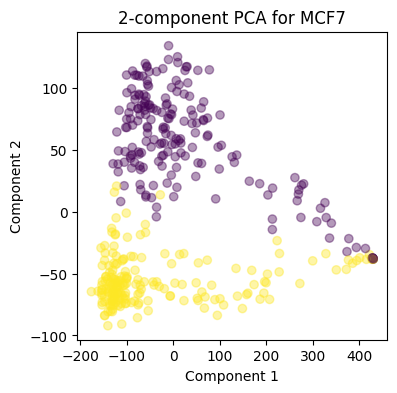

Unlike for the HCC1806, there appears to be a certain extent of linear
separability which could definitely be useful in the circumstance that
we decided to use it in some of our models.

#### Multidimensional Scaling (MDS)<a href="#Multidimensional-Scaling-(MDS)" class="anchor-link">¶</a>

reduces dimensionality while trying to preserve the distances between
the instances.

In \[ \]:

    mds = MDS(n_components=2, random_state=42, normalized_stress='auto')
    X2_reduced_mds = mds.fit_transform(X2)

In \[ \]:

    plt.figure(figsize=(4, 4))
    plt.scatter(X2_reduced_mds[:, 0], X2_reduced_mds[:, 1], alpha=0.4, c=y_mcf)
    plt.title("2-component MDS for MCF7")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

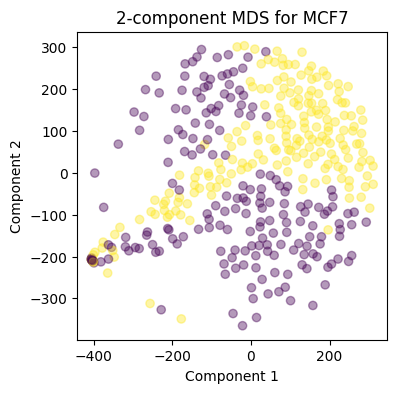

#### Isomap<a href="#Isomap" class="anchor-link">¶</a>

creates a graph by connecting each instance to its nearest neighbors,
then reduces dimensionality while trying to preserve the geodesic
distances between the instances.

In \[ \]:

    isomap = Isomap(n_components=2)
    X2_reduced_isomap = isomap.fit_transform(X2)

In \[ \]:

    plt.figure(figsize=(4, 4))
    plt.scatter(X2_reduced_isomap[:, 0], X2_reduced_isomap[:, 1], alpha=0.4, c=y_mcf)
    plt.title("2-component Isomap for MCF7")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

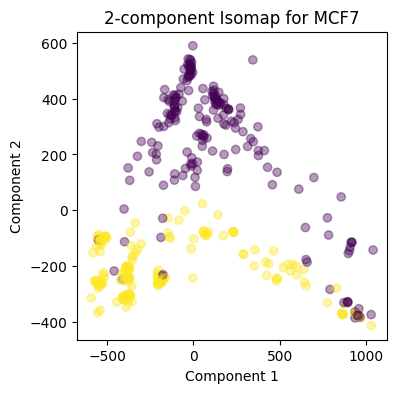

#### t-Distributed Stochastic Neighbor Embedding (t-SNE)<a href="#t-Distributed-Stochastic-Neighbor-Embedding-(t-SNE)"
class="anchor-link">¶</a>

reduces dimensionality while trying to keep similar instances close and
dissimilar instances apart. It is mostly used for visualization, in
particular to visualize clusters of instances in high-dimensional space
(e.g., to visualize the MNIST images in 2D).

In \[ \]:

    tsne = TSNE(n_components=2, init="random", learning_rate="auto",
                random_state=42)
    X2_reduced_tsne = tsne.fit_transform(X2)

In \[ \]:

    plt.figure(figsize=(4, 4))
    plt.scatter(X2_reduced_tsne[:, 0], X2_reduced_tsne[:, 1], alpha=0.4, c=y_mcf)
    plt.title("2-component t-SNE for MCF7")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

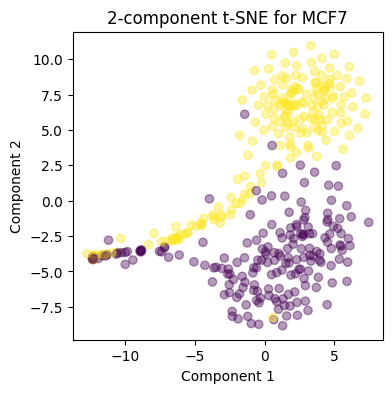

### Understanding the results<a href="#Understanding-the-results" class="anchor-link">¶</a>

After having carefully analysed and plotted various dimensionality
reductions on both the HCC1806 and MCF7 dataframes we can see how a 2
component division of the data actually renders it linearly separable in
some instances (such as PCA for MCF7). Nonetheless the relatively low
explained variance from the PCA might hinder its performance and hence
reduce its potential in model implementation. The 3 component PCA was
not displayed as the increase in explained variance was again not as
beneficial as one might hope. However, this poses the question of how
the PCA might have performed on the original data (it might be the case
that all the transformations applied to it might have actually caused
the PCA to perform worse).

### PCA on the original dataframes<a href="#PCA-on-the-original-dataframes" class="anchor-link">¶</a>

In \[ \]:

    hcc_smarts_df = add_label_T(unfilt_hcc_smarts)
    mcf_smarts_df = add_label_T(unfilt_mcf_smarts)

    X1 = hcc_smarts_df.loc[:,hcc_smarts_df.columns!='label']
    X2 = mcf_smarts_df.loc[:,mcf_smarts_df.columns!='label']
    y_hcc = hcc_smarts_df['label']
    y_mcf = mcf_smarts_df['label']
    display(X1)
    display(X2)

|                                                                      | WASH7P | CICP27 | DDX11L17 | WASH9P | OR4F29 | MTND1P23 | MTND2P28 | MTCO1P12 | MTCO2P12 | MTATP8P1 | ... | MT-TH | MT-TS2 | MT-TL2 | MT-ND5 | MT-ND6 | MT-TE | MT-CYB | MT-TT | MT-TP | MAFIP |
|----------------------------------------------------------------------|--------|--------|----------|--------|--------|----------|----------|----------|----------|----------|-----|-------|--------|--------|--------|--------|-------|--------|-------|-------|-------|
| output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam | 0      | 0      | 0        | 0      | 2      | 250      | 54       | 1740     | 6        | 1        | ... | 17    | 5      | 15     | 3852   | 900    | 22    | 4208   | 26    | 66    | 0     |
| output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam  | 0      | 0      | 0        | 0      | 0      | 424      | 100      | 2340     | 5        | 1        | ... | 49    | 29     | 36     | 7457   | 1439   | 43    | 6491   | 62    | 71    | 4     |
| output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam    | 0      | 0      | 0        | 0      | 0      | 11       | 0        | 22       | 0        | 0        | ... | 0     | 0      | 0      | 93     | 12     | 0     | 25     | 0     | 1     | 0     |
| output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam   | 0      | 0      | 0        | 0      | 0      | 63       | 16       | 1020     | 3        | 0        | ... | 43    | 17     | 8      | 1479   | 234    | 0     | 4819   | 11    | 3     | 7     |
| output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam     | 0      | 0      | 0        | 0      | 0      | 27       | 3        | 303      | 0        | 0        | ... | 0     | 0      | 3      | 303    | 33     | 0     | 310    | 4     | 9     | 0     |
| ...                                                                  | ...    | ...    | ...      | ...    | ...    | ...      | ...      | ...      | ...      | ...      | ... | ...   | ...    | ...    | ...    | ...    | ...   | ...    | ...   | ...   | ...   |
| output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam | 0      | 0      | 0        | 1      | 0      | 146      | 47       | 961      | 1        | 0        | ... | 25    | 17     | 11     | 2926   | 423    | 26    | 3719   | 42    | 48    | 3     |
| output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam | 0      | 0      | 0        | 0      | 0      | 37       | 6        | 372      | 0        | 0        | ... | 2     | 1      | 3      | 688    | 114    | 1     | 984    | 1     | 18    | 0     |
| output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam   | 0      | 0      | 0        | 1      | 0      | 83       | 30       | 1128     | 4        | 0        | ... | 9     | 6      | 23     | 2999   | 486    | 4     | 2256   | 15    | 36    | 2     |
| output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam  | 0      | 0      | 0        | 0      | 0      | 47       | 7        | 258      | 1        | 0        | ... | 2     | 3      | 3      | 611    | 75     | 4     | 981    | 6     | 8     | 1     |
| output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam  | 0      | 0      | 0        | 0      | 0      | 249      | 38       | 980      | 0        | 0        | ... | 14    | 3      | 15     | 2460   | 513    | 20    | 2039   | 34    | 79    | 5     |

243 rows × 23396 columns

|                                                          | WASH7P | MIR6859-1 | WASH9P | OR4F29 | MTND1P23 | MTND2P28 | MTCO1P12 | MTCO2P12 | MTATP8P1 | MTATP6P1 | ... | MT-TH | MT-TS2 | MT-TL2 | MT-ND5 | MT-ND6 | MT-TE | MT-CYB | MT-TT | MT-TP | MAFIP |
|----------------------------------------------------------|--------|-----------|--------|--------|----------|----------|----------|----------|----------|----------|-----|-------|--------|--------|--------|--------|-------|--------|-------|-------|-------|
| output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam | 0      | 0         | 1      | 0      | 0        | 2        | 2        | 0        | 0        | 29       | ... | 0     | 0      | 0      | 505    | 147    | 4     | 270    | 0     | 5     | 8     |
| output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam | 0      | 0         | 0      | 0      | 0        | 0        | 0        | 0        | 0        | 0        | ... | 1     | 1      | 0      | 1      | 0      | 0     | 1      | 0     | 0     | 0     |
| output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam | 0      | 0         | 0      | 0      | 0        | 1        | 1        | 1        | 0        | 12       | ... | 0     | 0      | 0      | 1      | 0      | 0     | 76     | 0     | 0     | 0     |
| output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam   | 0      | 0         | 0      | 0      | 0        | 0        | 0        | 0        | 0        | 7        | ... | 1     | 0      | 0      | 44     | 8      | 0     | 66     | 0     | 1     | 0     |
| output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam   | 0      | 0         | 0      | 0      | 0        | 0        | 0        | 0        | 0        | 68       | ... | 0     | 0      | 0      | 237    | 31     | 3     | 727    | 0     | 0     | 0     |
| ...                                                      | ...    | ...       | ...    | ...    | ...      | ...      | ...      | ...      | ...      | ...      | ... | ...   | ...    | ...    | ...    | ...    | ...   | ...    | ...   | ...   | ...   |
| output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam | 0      | 0         | 0      | 0      | 0        | 0        | 1        | 0        | 0        | 49       | ... | 0     | 0      | 1      | 341    | 46     | 1     | 570    | 0     | 0     | 0     |
| output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam | 0      | 0         | 1      | 0      | 0        | 2        | 5        | 5        | 0        | 370      | ... | 0     | 0      | 2      | 1612   | 215    | 6     | 3477   | 3     | 7     | 6     |
| output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam | 1      | 0         | 1      | 0      | 0        | 7        | 0        | 0        | 0        | 33       | ... | 0     | 0      | 0      | 62     | 20     | 0     | 349    | 0     | 2     | 0     |
| output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam | 0      | 0         | 4      | 1      | 0        | 29       | 4        | 0        | 0        | 228      | ... | 3     | 0      | 2      | 1934   | 575    | 7     | 2184   | 2     | 28    | 1     |
| output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam | 1      | 0         | 5      | 0      | 0        | 5        | 3        | 0        | 0        | 71       | ... | 5     | 2      | 3      | 1328   | 490    | 4     | 1149   | 2     | 11    | 4     |

383 rows × 22934 columns

In \[ \]:

    #Running PCA on the hcc dataframe
    pca = PCA(n_components=2)
    pca.fit(X1)

    print(f"The 2-component explained variance is divided as follows: {pca.explained_variance_ratio_}")
    print(f"It accounts for a total of: {round(sum(pca.explained_variance_ratio_)*100,2)}% of the total variance")
    red_X1 = pd.DataFrame(pca.transform(X1))
    display(red_X1)
    plt.figure(figsize=(4, 4))
    plt.scatter(red_X1[0], red_X1[1], alpha=0.4, c=y_hcc)
    plt.title("2-component PCA for the original HCC1806 df")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

    The 2-component explained variance is divided as follows: [0.48773783 0.11690897]
    It accounts for a total of: 60.46% of the total variance

|     | 0             | 1             |
|-----|---------------|---------------|
| 0   | 8508.231537   | 6572.525591   |
| 1   | 66982.567454  | -34314.867502 |
| 2   | -56024.107315 | 7548.406871   |
| 3   | 53124.609960  | -43416.534007 |
| 4   | -35092.681963 | 10995.846101  |
| ... | ...           | ...           |
| 238 | -5887.971793  | -14855.195557 |
| 239 | -43546.752863 | 776.491787    |
| 240 | 19297.497843  | -11357.496114 |
| 241 | -40565.267959 | 2338.182899   |
| 242 | -13693.381360 | -1698.118063  |

243 rows × 2 columns

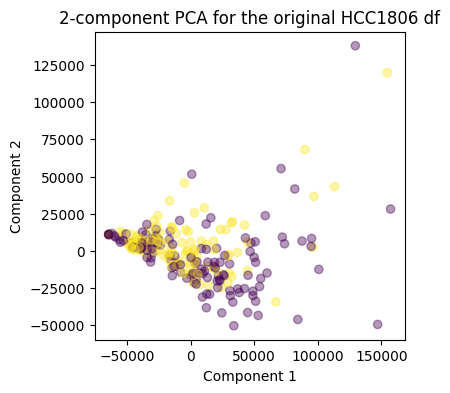

In \[ \]:

    #Running PCA on the mcf dataframe
    pca = PCA(n_components=2)
    pca.fit(X2)

    print(f"The 2-component explained variance is divided as follows: {pca.explained_variance_ratio_}")
    print(f"It accounts for a total of: {round(sum(pca.explained_variance_ratio_)*100,2)}% of the total variance")
    red_X2 = pd.DataFrame(pca.transform(X2))
    display(red_X2)
    plt.figure(figsize=(4, 4))
    plt.scatter(red_X2[0], red_X2[1], alpha=0.4, c=y_mcf)
    plt.title("2-component PCA for the original MCF7 df")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

    The 2-component explained variance is divided as follows: [0.52781575 0.17881458]
    It accounts for a total of: 70.66% of the total variance

|     | 0             | 1             |
|-----|---------------|---------------|
| 0   | 13131.081856  | -12716.489155 |
| 1   | -47422.754025 | -24042.707166 |
| 2   | 94682.412774  | -3885.918848  |
| 3   | -46804.508372 | -23673.963171 |
| 4   | -37054.766246 | -10017.024374 |
| ... | ...           | ...           |
| 378 | -30423.989675 | 258.437947    |
| 379 | -5965.250695  | 102.228087    |
| 380 | 4265.961618   | -21684.709634 |
| 381 | 41724.822448  | -23590.325613 |
| 382 | 66740.692486  | -1494.780328  |

383 rows × 2 columns

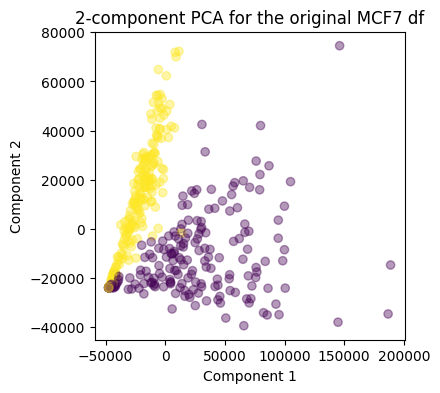

Indeed, it does seem that although like in the log transformed data
there is some linear separability, this PCA actually holds a higher
amount of explained variance. Therefore, when deciding to use PCA in the
model implementation (if it seems reasonable to do so), it might make
more sense to use it on the unfiltered data directly.

## Models<a href="#Models" class="anchor-link">¶</a>

To build our models we use the filtered and normalised data, as it is
easier to build better models on preprocessed data, than on raw data.

### SmartSeq MCF7<a href="#SmartSeq-MCF7" class="anchor-link">¶</a>

In this section we fit a classifier for the dataset SmartSeq MCF7. From
our preliminary analysis it seemed that a linear model could do a very
good job, thus we try Logistic Regression. Linear models, not being
complex generalize well to new data, without risking overfitting;
moreover, they give us a great result interpretability.

In \[ \]:

    df = pd.read_csv("data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt", sep=" ")
    df = add_label_T(df, dropname=True)
    df

Out\[ \]:

|     | CYP1B1 | CYP1B1-AS1 | CYP1A1 | NDRG1 | DDIT4 | PFKFB3 | HK2  | AREG | MYBL2 | ADM | ... | DNAI7 | MAFG | LZTR1 | BCO2 | GRIK5 | SLC25A27 | DENND5A | CDK5R1 | FAM13A-AS1 | label |
|-----|--------|------------|--------|-------|-------|--------|------|------|-------|-----|-----|-------|------|-------|------|-------|----------|---------|--------|------------|-------|
| 0   | 343    | 140        | 0      | 0     | 386   | 75     | 0    | 0    | 476   | 0   | ... | 0     | 17   | 59    | 0    | 0     | 0        | 51      | 0      | 0          | 1     |
| 1   | 131    | 59         | 0      | 1     | 289   | 42     | 0    | 856  | 1586  | 0   | ... | 0     | 1    | 25    | 0    | 0     | 0        | 34      | 0      | 0          | 1     |
| 2   | 452    | 203        | 0      | 0     | 0     | 0      | 0    | 0    | 775   | 0   | ... | 0     | 23   | 0     | 0    | 0     | 0        | 0       | 0      | 0          | 1     |
| 3   | 27     | 7          | 0      | 0     | 288   | 214    | 15   | 242  | 1191  | 0   | ... | 0     | 3    | 10    | 0    | 0     | 0        | 4       | 0      | 0          | 1     |
| 4   | 5817   | 2669       | 0      | 654   | 2484  | 1603   | 748  | 436  | 0     | 0   | ... | 0     | 63   | 0     | 0    | 0     | 0        | 60      | 0      | 0          | 0     |
| ... | ...    | ...        | ...    | ...   | ...   | ...    | ...  | ...  | ...   | ... | ... | ...   | ...  | ...   | ...  | ...   | ...      | ...     | ...    | ...        | ...   |
| 245 | 196    | 102        | 1      | 243   | 266   | 278    | 78   | 1    | 199   | 0   | ... | 0     | 1    | 0     | 0    | 0     | 0        | 45      | 19     | 0          | 1     |
| 246 | 504    | 238        | 0      | 62    | 417   | 932    | 275  | 0    | 33    | 0   | ... | 0     | 0    | 0     | 0    | 0     | 0        | 0       | 0      | 0          | 1     |
| 247 | 34565  | 13717      | 11274  | 1263  | 4256  | 5663   | 701  | 0    | 0     | 0   | ... | 0     | 45   | 0     | 0    | 0     | 0        | 140     | 0      | 32         | 0     |
| 248 | 20024  | 7835       | 563    | 925   | 12733 | 2187   | 1141 | 0    | 20    | 81  | ... | 0     | 57   | 8     | 0    | 0     | 0        | 7       | 0      | 11         | 0     |
| 249 | 5953   | 2367       | 522    | 1572  | 2275  | 3269   | 2247 | 169  | 2     | 0   | ... | 0     | 165  | 0     | 0    | 0     | 0        | 37      | 0      | 12         | 0     |

250 rows × 3001 columns

Given our high-dimensionality context, we use the L1 penanlty in our
logistic regression in order to induce sparsity in the model, thus
finding the responsible genes.

In \[ \]:

    X_train, X_test, y_train, y_test = train_test_split(df.drop("label", axis=1), df["label"], test_size=0.2, random_state=42)

We try to find the best value for C, the inverse of the regularization
coefficient.

In \[ \]:

    clf = LogisticRegression(penalty="l1", solver="liblinear", random_state=42)
    param_grid = {
        "C": [10**x for x in range(-3, 3)]
    }

    grid_search = GridSearchCV(clf, param_grid)
    grid_search.fit(X_train, y_train)

    print("Best value of C:", grid_search.best_params_["C"])
    print("Cross validation mean accuracy:", grid_search.best_score_)

    Best value of C: 0.01
    Cross validation mean accuracy: 1.0

Apparently, C=0.01 scores perfectly on the cross validation in the train
dataset, however it seems a too high regularization, that could lead to
underfit the data, thus we are going to try C=0.1.

In \[ \]:

    cross_val_score(LogisticRegression(penalty="l1", solver="liblinear", random_state=42), X_train, y_train).mean()

Out\[ \]:

    1.0

C=0.1 scores perfectly on the cross validation, thus we are going to
test it.

In \[ \]:

    log_reg = LogisticRegression(penalty="l1", C=0.1, solver="liblinear", random_state=42)
    log_reg.fit(X_train, y_train)
    log_reg.score(X_test, y_test)

Out\[ \]:

    1.0

Again a perfect score, we can conclude that our model is very good. Now
let's see how many, and which, genes influence the label.

In \[ \]:

    def relevant_genes(feature_names, coef):
        non_zero_coef = list()
        for i, c in enumerate(coef):
            if abs(c) > 0:
                non_zero_coef.append(feature_names[i])
        non_zero_coef.sort()

        print("Number of non zero coeffiecients:", len(non_zero_coef))
        print("Relevant genes:", non_zero_coef)

In \[ \]:

    feature_names = df.columns.tolist()
    coef = log_reg.coef_.tolist()[0]

    relevant_genes(feature_names, coef)

    Number of non zero coeffiecients: 36
    Relevant genes: ['ACTG1', 'ALDOA', 'ATP1A1', 'BEST1', 'CEACAM5', 'CYP1B1', 'DDIT4', 'DDX5', 'DHCR7', 'DSP', 'EMP2', 'FLNA', 'FTH1', 'FTL', 'GAPDH', 'GATA3', 'GPI', 'HSPB1', 'LDHA', 'LMNA', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND4', 'MT-RNR2', 'NME1-NME2', 'NR4A1', 'PGK1', 'SLC9A3R1', 'SULF2', 'TMSB10', 'TMSB4X', 'TUBA1B', 'UBB', 'XBP1']

We can very well see how the L1 penalty induced sparsity in the model:
out of 3000 genes, only 36 are being used by the model.

### SmartSeq HCC1806<a href="#SmartSeq-HCC1806" class="anchor-link">¶</a>

Again, we try Logistic Regression and see how it performs.

In \[ \]:

    df = pd.read_csv("data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt", sep=" ")
    df = add_label_T(df, dropname=True)
    df

Out\[ \]:

|     | DDIT4 | ANGPTL4 | CALML5 | KRT14 | CCNB1 | IGFBP3 | AKR1C2 | KRT6A | NDRG1 | KRT4 | ... | ZYG11A | NRG1 | RBMS3 | VCPIP1 | LINC02693 | OR8B9P | NEAT1 | ZDHHC23 | ODAD2 | label |
|-----|-------|---------|--------|-------|-------|--------|--------|-------|-------|------|-----|--------|------|-------|--------|-----------|--------|-------|---------|-------|-------|
| 0   | 0     | 48      | 0      | 321   | 298   | 82     | 6250   | 634   | 0     | 0    | ... | 10     | 136  | 0     | 0      | 29        | 0      | 29    | 0       | 0     | 1     |
| 1   | 8739  | 2101    | 55     | 96    | 1824  | 1938   | 62     | 0     | 522   | 413  | ... | 0      | 264  | 0     | 134    | 68        | 0      | 213   | 0       | 0     | 0     |
| 2   | 13098 | 14032   | 0      | 0     | 1616  | 247    | 430    | 907   | 348   | 0    | ... | 0      | 38   | 0     | 0      | 0         | 0      | 92    | 0       | 0     | 0     |
| 3   | 2880  | 356     | 0      | 6211  | 3     | 3430   | 79     | 1953  | 592   | 176  | ... | 0      | 16   | 0     | 4      | 1         | 0      | 1     | 0       | 0     | 0     |
| 4   | 7777  | 5661    | 4383   | 0     | 145   | 4618   | 246    | 85    | 206   | 0    | ... | 1      | 25   | 0     | 0      | 0         | 0      | 128   | 0       | 0     | 0     |
| ... | ...   | ...     | ...    | ...   | ...   | ...    | ...    | ...   | ...   | ...  | ... | ...    | ...  | ...   | ...    | ...       | ...    | ...   | ...     | ...   | ...   |
| 177 | 79    | 5       | 0      | 2098  | 554   | 99     | 798    | 4211  | 64    | 0    | ... | 0      | 264  | 0     | 10     | 34        | 0      | 24    | 0       | 0     | 1     |
| 178 | 167   | 1       | 0      | 27    | 3585  | 134    | 3      | 596   | 11    | 0    | ... | 0      | 120  | 25    | 0      | 53        | 0      | 177   | 53      | 0     | 1     |
| 179 | 10186 | 3147    | 0      | 149   | 1012  | 111    | 716    | 617   | 744   | 0    | ... | 0      | 55   | 0     | 157    | 43        | 0      | 113   | 0       | 0     | 0     |
| 180 | 238   | 41      | 2867   | 814   | 2207  | 297    | 1023   | 2879  | 1     | 0    | ... | 0      | 42   | 0     | 26     | 0         | 0      | 13    | 5       | 0     | 1     |
| 181 | 60    | 0       | 0      | 7     | 477   | 10     | 845    | 1222  | 1     | 0    | ... | 7      | 255  | 0     | 32     | 25        | 0      | 13    | 4       | 0     | 1     |

182 rows × 3001 columns

In \[ \]:

    X_train, X_test, y_train, y_test = train_test_split(df.drop("label", axis=1), df["label"], test_size=0.2, random_state=42)

This time we add also the L2 penalty in our grid search, to see if it
performs better.

In \[ \]:

    clf = LogisticRegression(solver="liblinear", random_state=42)
    param_grid = {
        "penalty": ["l1", "l2"],
        "C": [10**x for x in range(-3, 3)]
    }

    grid_search = GridSearchCV(clf, param_grid)
    grid_search.fit(X_train, y_train)

    print("Best parameters", grid_search.best_params_)
    print("Cross validation mean accuracy:", grid_search.best_score_)

    Best parameters {'C': 1, 'penalty': 'l1'}
    Cross validation mean accuracy: 0.993103448275862

The score is not perfect, but almost; we can try to zoom in the range
0.1-2 to see if we find a better value for C.

In \[ \]:

    clf = LogisticRegression(penalty="l1", solver="liblinear", random_state=42)
    param_grid = {
        "C": np.arange(0.1, 2, 0.1)
    }

    grid_search = GridSearchCV(clf, param_grid)
    grid_search.fit(X_train, y_train)

    print("Best value of C:", grid_search.best_params_["C"])
    print("Cross validation mean accuracy:", grid_search.best_score_)

    Best value of C: 1.2000000000000002
    Cross validation mean accuracy: 1.0

With C=1.2 the score on the cross validation is perfect, now we test our
model on the test set (this dataset contains only 182 samples, so we do
not have a validation set).

In \[ \]:

    log_reg = LogisticRegression(penalty="l1", C=1.2, solver="liblinear", random_state=42)
    log_reg.fit(X_train, y_train)
    log_reg.score(X_test, y_test)

Out\[ \]:

    1.0

We got a perfect score, so we can stick to this linear model, without
the need to explore more complex models. Again we can see the genes
whose associated coefficient in the regression is not 0; in this case C
is larger, and so the regularization milder, hence the model less
sparse.

In \[ \]:

    feature_names = df.columns.tolist()
    coef = log_reg.coef_.tolist()[0]

    relevant_genes(feature_names, coef)

    Number of non zero coeffiecients: 169
    Relevant genes: ['ACTG1', 'ACTN1', 'AHNAK', 'AKR1C2', 'AKR1C3', 'ALDOA', 'ALDOC', 'ANGPTL4', 'ANXA1', 'ARRDC3', 'B2M', 'BEST1', 'BHLHE40', 'BIRC5', 'BLCAP', 'BNIP3', 'BNIP3L', 'BRD2', 'C4orf3', 'CALM2', 'CAV1', 'CCNB1', 'CD44', 'CD59', 'CDC20', 'CEACAM5', 'COL17A1', 'CSTB', 'CTSB', 'DDIT4', 'DKK1', 'DUSP1', 'EGLN3', 'EPHA2', 'ERO1A', 'EZR', 'F3', 'FAM162A', 'FAM83A', 'FGFBP1', 'FLNA', 'FOS', 'FOSL1', 'FOSL2', 'FSCN1', 'FTH1', 'FTL', 'G0S2', 'GLUL', 'GPI', 'GPRC5A', 'GPX2', 'GRN', 'H1-0', 'H2AZ1', 'H4C3', 'HLA-A', 'HMGA1', 'HSP90AA1', 'HSP90B1', 'HSPA5', 'HSPA8', 'IDI1', 'IGFBP3', 'INSIG1', 'ITGA6', 'JUP', 'KCTD11', 'KDM5B', 'KPNA2', 'KRT13', 'KRT14', 'KRT17', 'KRT18', 'KRT19', 'KRT4', 'KRT5', 'KRT6A', 'KRT7', 'KRT8', 'LAMA3', 'LAMB3', 'LAMC1', 'LAMC2', 'LDHA', 'LDHB', 'LMNA', 'MAL2', 'MALAT1', 'MCM3', 'MIF', 'MIF-AS1', 'MMP1', 'MRNIP', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND4', 'MT-ND4L', 'MT-ND5', 'MT-RNR1', 'MT-RNR2', 'MT2A', 'MYBL2', 'NDRG1', 'NEU1', 'NFKBIA', 'NOLC1', 'NQO1', 'P4HA1', 'PFKFB3', 'PGK1', 'PHLDA1', 'PLAU', 'PLIN2', 'PLK2', 'PLOD2', 'POLR2A', 'PPARG', 'PPP1R15A', 'PRDX1', 'PRNP', 'PRSS23', 'PSMD2', 'PXN', 'PYGB', 'S100A16', 'S100A2', 'SCD', 'SDHA', 'SEC61A1', 'SERPINB2', 'SERPINB5', 'SERPINE1', 'SFN', 'SLC20A1', 'SLC2A1', 'SLC38A2', 'SLC3A2', 'SLC6A8', 'SLC7A5', 'SLCO4A1', 'SPP1', 'SQLE', 'SQSTM1', 'SRM', 'SRXN1', 'ST14', 'STMN1', 'TCF19', 'TFRC', 'THBS1', 'TMSB10', 'TMSB4X', 'TNFRSF21', 'TPBG', 'TPX2', 'TRIM16', 'TUBA1B', 'TUBB', 'TUBB4B', 'TXN', 'TXNIP', 'TXNRD1', 'UBB', 'UCA1', 'UGDH', 'UPK1B', 'ZFP36L1']

Regarding SmartSeq, we used Logistic Regression in both cell types,
however the parameters used are slightly different. In both occasion we
used the L1 penalty, to induce sparsity in the model, and find the most
relevant genes. However, for MCF7 the regularization used was one order
of magnitude stronger, and thus we ended up with a smaller, and simpler,
model. On HCC1806 it wasn't possible to achieve a perfect score with
such a simple model, so we had to reduce the regularization and allow
for a more complex model.

As specified at the start of this section, we used the filtered and
normalised data to build our models, but what if we used the unfiltered
data, or the filtered but not normalised data? We are going to try the
model we selected earlier on these datasets, and see how large the
difference in performance is. We use the SmartSeq MCF7 dataset.

In \[ \]:

    df = pd.read_csv("data/SmartSeq/MCF7_SmartS_Unfiltered_Data.txt", sep=" ")
    df = add_label_T(df, dropname=True)
    df

Out\[ \]:

|     | WASH7P | MIR6859-1 | WASH9P | OR4F29 | MTND1P23 | MTND2P28 | MTCO1P12 | MTCO2P12 | MTATP8P1 | MTATP6P1 | ... | MT-TS2 | MT-TL2 | MT-ND5 | MT-ND6 | MT-TE | MT-CYB | MT-TT | MT-TP | MAFIP | label |
|-----|--------|-----------|--------|--------|----------|----------|----------|----------|----------|----------|-----|--------|--------|--------|--------|-------|--------|-------|-------|-------|-------|
| 0   | 0      | 0         | 1      | 0      | 0        | 2        | 2        | 0        | 0        | 29       | ... | 0      | 0      | 505    | 147    | 4     | 270    | 0     | 5     | 8     | 0     |
| 1   | 0      | 0         | 0      | 0      | 0        | 0        | 0        | 0        | 0        | 0        | ... | 1      | 0      | 1      | 0      | 0     | 1      | 0     | 0     | 0     | 0     |
| 2   | 0      | 0         | 0      | 0      | 0        | 1        | 1        | 1        | 0        | 12       | ... | 0      | 0      | 1      | 0      | 0     | 76     | 0     | 0     | 0     | 0     |
| 3   | 0      | 0         | 0      | 0      | 0        | 0        | 0        | 0        | 0        | 7        | ... | 0      | 0      | 44     | 8      | 0     | 66     | 0     | 1     | 0     | 1     |
| 4   | 0      | 0         | 0      | 0      | 0        | 0        | 0        | 0        | 0        | 68       | ... | 0      | 0      | 237    | 31     | 3     | 727    | 0     | 0     | 0     | 1     |
| ... | ...    | ...       | ...    | ...    | ...      | ...      | ...      | ...      | ...      | ...      | ... | ...    | ...    | ...    | ...    | ...   | ...    | ...   | ...   | ...   | ...   |
| 378 | 0      | 0         | 0      | 0      | 0        | 0        | 1        | 0        | 0        | 49       | ... | 0      | 1      | 341    | 46     | 1     | 570    | 0     | 0     | 0     | 1     |
| 379 | 0      | 0         | 1      | 0      | 0        | 2        | 5        | 5        | 0        | 370      | ... | 0      | 2      | 1612   | 215    | 6     | 3477   | 3     | 7     | 6     | 1     |
| 380 | 1      | 0         | 1      | 0      | 0        | 7        | 0        | 0        | 0        | 33       | ... | 0      | 0      | 62     | 20     | 0     | 349    | 0     | 2     | 0     | 0     |
| 381 | 0      | 0         | 4      | 1      | 0        | 29       | 4        | 0        | 0        | 228      | ... | 0      | 2      | 1934   | 575    | 7     | 2184   | 2     | 28    | 1     | 0     |
| 382 | 1      | 0         | 5      | 0      | 0        | 5        | 3        | 0        | 0        | 71       | ... | 2      | 3      | 1328   | 490    | 4     | 1149   | 2     | 11    | 4     | 0     |

383 rows × 22935 columns

For the unfilted data we have almost 23000 genes, a huge number!

In \[ \]:

    X_train, X_test, y_train, y_test = train_test_split(df.drop("label", axis=1), df["label"], test_size=0.2, random_state=42)

In \[ \]:

    log_reg = LogisticRegression(penalty="l1", C=0.1, solver="liblinear", random_state=42)
    log_reg.fit(X_train, y_train)
    log_reg.score(X_test, y_test)

Out\[ \]:

    0.987012987012987

The score achieved with the model selected on the filtered and
normalised dataset is still very good, now let's see how many of the
23000 genes our model uses.

In \[ \]:

    feature_names = df.columns.tolist()
    coef = log_reg.coef_.tolist()[0]

    relevant_genes(feature_names, coef)

    Number of non zero coeffiecients: 65
    Relevant genes: ['ACTB', 'ACTG1', 'ALDOA', 'ALG12', 'BAMBI', 'BCAS3', 'BEST1', 'CDH1', 'CEACAM5', 'CFL1', 'COPE', 'COX6C', 'CTSD', 'CYP1A1', 'CYP1B1', 'CYP1B1-AS1', 'DDIT4', 'DHCR7', 'DOT1L', 'EMP2', 'ENO1', 'FLNA', 'FTH1', 'GAPDH', 'GATA3', 'GFRA1', 'GNAS', 'GPI', 'H3-3B', 'HSPA8', 'KRT18', 'KRT19', 'KRT8', 'LY6E', 'MALAT1', 'MIF', 'MIF-AS1', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-RNR2', 'NME1-NME2', 'NR4A1', 'PFKFB3', 'PGK1', 'PKM', 'PPP1CA', 'PSMA7', 'RPL8', 'SCD', 'SERF2', 'SLC2A1', 'SLC39A6', 'SLC9A3R1', 'SQSTM1', 'STARD10', 'SULF2', 'TFF3', 'TMSB10', 'TMSB4X', 'TUBA1B', 'TUBB4B', 'UBB', 'XBP1']

The model needs only 65 genes to get an accuracy of 98.7%. This is not
perfect as on the preprocessed data, but still good. Now let's see if
the situation changes with the filtered data.

In \[ \]:

    df = pd.read_csv("data/SmartSeq/MCF7_SmartS_Filtered_Data.txt", sep=" ")
    df = add_label_T(df, dropname=True)
    df

Out\[ \]:

|     | WASH7P | MIR6859-1 | WASH9P | OR4F29 | MTND1P23 | MTND2P28 | MTCO1P12 | MTCO2P12 | MTATP8P1 | MTATP6P1 | ... | MT-TS2 | MT-TL2 | MT-ND5 | MT-ND6 | MT-TE | MT-CYB | MT-TT | MT-TP | MAFIP | label |
|-----|--------|-----------|--------|--------|----------|----------|----------|----------|----------|----------|-----|--------|--------|--------|--------|-------|--------|-------|-------|-------|-------|
| 0   | 0      | 0         | 1      | 0      | 0        | 2        | 2        | 0        | 0        | 29       | ... | 0      | 0      | 505    | 147    | 4     | 270    | 0     | 5     | 8     | 0     |
| 1   | 0      | 0         | 0      | 0      | 0        | 1        | 1        | 1        | 0        | 12       | ... | 0      | 0      | 1      | 0      | 0     | 76     | 0     | 0     | 0     | 0     |
| 2   | 0      | 0         | 0      | 0      | 0        | 0        | 0        | 0        | 0        | 68       | ... | 0      | 0      | 237    | 31     | 3     | 727    | 0     | 0     | 0     | 1     |
| 3   | 0      | 0         | 1      | 0      | 0        | 1        | 3        | 0        | 0        | 203      | ... | 0      | 0      | 894    | 113    | 3     | 2717   | 1     | 1     | 0     | 1     |
| 4   | 0      | 0         | 10     | 0      | 0        | 3        | 10       | 1        | 0        | 691      | ... | 0      | 3      | 1279   | 131    | 0     | 9326   | 1     | 1     | 0     | 1     |
| ... | ...    | ...       | ...    | ...    | ...      | ...      | ...      | ...      | ...      | ...      | ... | ...    | ...    | ...    | ...    | ...   | ...    | ...   | ...   | ...   | ...   |
| 308 | 0      | 0         | 0      | 0      | 0        | 0        | 1        | 0        | 0        | 49       | ... | 0      | 1      | 341    | 46     | 1     | 570    | 0     | 0     | 0     | 1     |
| 309 | 0      | 0         | 1      | 0      | 0        | 2        | 5        | 5        | 0        | 370      | ... | 0      | 2      | 1612   | 215    | 6     | 3477   | 3     | 7     | 6     | 1     |
| 310 | 1      | 0         | 1      | 0      | 0        | 7        | 0        | 0        | 0        | 33       | ... | 0      | 0      | 62     | 20     | 0     | 349    | 0     | 2     | 0     | 0     |
| 311 | 0      | 0         | 4      | 1      | 0        | 29       | 4        | 0        | 0        | 228      | ... | 0      | 2      | 1934   | 575    | 7     | 2184   | 2     | 28    | 1     | 0     |
| 312 | 1      | 0         | 5      | 0      | 0        | 5        | 3        | 0        | 0        | 71       | ... | 2      | 3      | 1328   | 490    | 4     | 1149   | 2     | 11    | 4     | 0     |

313 rows × 18946 columns

In \[ \]:

    X_train, X_test, y_train, y_test = train_test_split(df.drop("label", axis=1), df["label"], test_size=0.2, random_state=42)

In \[ \]:

    log_reg = LogisticRegression(penalty="l1", C=0.1, solver="liblinear", random_state=42)
    log_reg.fit(X_train, y_train)
    log_reg.score(X_test, y_test)

Out\[ \]:

    0.9841269841269841

In \[ \]:

    feature_names = df.columns.tolist()
    coef = log_reg.coef_.tolist()[0]

    relevant_genes(feature_names, coef)

    Number of non zero coeffiecients: 50
    Relevant genes: ['ACTB', 'ACTG1', 'ALDOA', 'ATP1A1', 'ATP5F1B', 'BEST1', 'BSG', 'CFL1', 'COPE', 'CTSD', 'CYP1B1', 'CYP1B1-AS1', 'DDIT4', 'DYNC2I2', 'ENO1', 'FLNA', 'FTH1', 'GAPDH', 'GATA3', 'GNAS', 'GPI', 'GSTM3', 'HSPB1', 'KRT18', 'KRT19', 'KRT8', 'KRT80', 'KRT81', 'LDHA', 'MCM7', 'MIF', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND4', 'MYL6', 'NME1-NME2', 'PFKFB3', 'PGK1', 'PKM', 'SLC2A1', 'SLC9A3R1', 'SULF2', 'TFF1', 'TK1', 'TMSB10', 'TUBA1B', 'TUBB4B', 'UBC']

The situation did not improve. This would lead to believe that the
normalisation is crucial for the performance of the model; however we
have to note that the filtered and normalised dataset is further
filtered and includes only 3000 genes, as opposed to the almost 19000
present in the only filtered dataset. To see if the normalisation has
some influence, we can shrink the unfiltered dataset to include only the
36 genes used by our model on the filtered and normalised dataset, and
see if the performance differs.

In \[ \]:

    genes = ['ACTG1', 'ALDOA', 'ATP1A1', 'BEST1', 'CEACAM5', 'CYP1B1', 'DDIT4', 'DDX5', 'DHCR7', 'DSP', 'EMP2', 'FLNA', 'FTH1', 'FTL', 'GAPDH', 'GATA3', 'GPI', 'HSPB1', 'LDHA', 'LMNA', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND4', 'MT-RNR2', 'NME1-NME2', 'NR4A1', 'PGK1', 'SLC9A3R1', 'SULF2', 'TMSB10', 'TMSB4X', 'TUBA1B', 'UBB', 'XBP1']

In \[ \]:

    df = pd.read_csv("data/SmartSeq/MCF7_SmartS_Unfiltered_Data.txt", sep=" ")
    df = add_label_T(df, dropname=True)
    df

Out\[ \]:

|     | WASH7P | MIR6859-1 | WASH9P | OR4F29 | MTND1P23 | MTND2P28 | MTCO1P12 | MTCO2P12 | MTATP8P1 | MTATP6P1 | ... | MT-TS2 | MT-TL2 | MT-ND5 | MT-ND6 | MT-TE | MT-CYB | MT-TT | MT-TP | MAFIP | label |
|-----|--------|-----------|--------|--------|----------|----------|----------|----------|----------|----------|-----|--------|--------|--------|--------|-------|--------|-------|-------|-------|-------|
| 0   | 0      | 0         | 1      | 0      | 0        | 2        | 2        | 0        | 0        | 29       | ... | 0      | 0      | 505    | 147    | 4     | 270    | 0     | 5     | 8     | 0     |
| 1   | 0      | 0         | 0      | 0      | 0        | 0        | 0        | 0        | 0        | 0        | ... | 1      | 0      | 1      | 0      | 0     | 1      | 0     | 0     | 0     | 0     |
| 2   | 0      | 0         | 0      | 0      | 0        | 1        | 1        | 1        | 0        | 12       | ... | 0      | 0      | 1      | 0      | 0     | 76     | 0     | 0     | 0     | 0     |
| 3   | 0      | 0         | 0      | 0      | 0        | 0        | 0        | 0        | 0        | 7        | ... | 0      | 0      | 44     | 8      | 0     | 66     | 0     | 1     | 0     | 1     |
| 4   | 0      | 0         | 0      | 0      | 0        | 0        | 0        | 0        | 0        | 68       | ... | 0      | 0      | 237    | 31     | 3     | 727    | 0     | 0     | 0     | 1     |
| ... | ...    | ...       | ...    | ...    | ...      | ...      | ...      | ...      | ...      | ...      | ... | ...    | ...    | ...    | ...    | ...   | ...    | ...   | ...   | ...   | ...   |
| 378 | 0      | 0         | 0      | 0      | 0        | 0        | 1        | 0        | 0        | 49       | ... | 0      | 1      | 341    | 46     | 1     | 570    | 0     | 0     | 0     | 1     |
| 379 | 0      | 0         | 1      | 0      | 0        | 2        | 5        | 5        | 0        | 370      | ... | 0      | 2      | 1612   | 215    | 6     | 3477   | 3     | 7     | 6     | 1     |
| 380 | 1      | 0         | 1      | 0      | 0        | 7        | 0        | 0        | 0        | 33       | ... | 0      | 0      | 62     | 20     | 0     | 349    | 0     | 2     | 0     | 0     |
| 381 | 0      | 0         | 4      | 1      | 0        | 29       | 4        | 0        | 0        | 228      | ... | 0      | 2      | 1934   | 575    | 7     | 2184   | 2     | 28    | 1     | 0     |
| 382 | 1      | 0         | 5      | 0      | 0        | 5        | 3        | 0        | 0        | 71       | ... | 2      | 3      | 1328   | 490    | 4     | 1149   | 2     | 11    | 4     | 0     |

383 rows × 22935 columns

In \[ \]:

    X, y = df[genes], df["label"]

In \[ \]:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In \[ \]:

    log_reg = LogisticRegression(penalty="l1", C=0.1, solver="liblinear", random_state=42)
    log_reg.fit(X_train, y_train)
    log_reg.score(X_test, y_test)

Out\[ \]:

    1.0

On this exremely filtered dataset the score is perfect, thus the
normalisation is not crucial, and filtering is more important. While
Logistic Regression with the L1 penalty already selects features on its
own, having a filtered dataset definitely helps the process, and leads
to better models.

### DropSeq MCF7<a href="#DropSeq-MCF7" class="anchor-link">¶</a>

In \[ \]:

    df = pd.read_csv("data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt", sep=" ")
    df = add_label_T(df, dropname=True)
    df

Out\[ \]:

|       | MALAT1 | MT-RNR2 | NEAT1 | H1-5 | TFF1 | MT-RNR1 | H4C3 | GDF15 | KRT81 | MT-CO3 | ... | SKIDA1 | MICALL1 | RARG | MYO1F | BRWD1-AS2 | RPS19BP1 | AUNIP | TNK2 | SUDS3 | label |
|-------|--------|---------|-------|------|------|---------|------|-------|-------|--------|-----|--------|---------|------|-------|-----------|----------|-------|------|-------|-------|
| 0     | 1      | 0       | 0     | 0    | 4    | 0       | 0    | 0     | 0     | 0      | ... | 0      | 0       | 0    | 0     | 0         | 0        | 0     | 0    | 0     | 1     |
| 1     | 3      | 0       | 0     | 0    | 1    | 0       | 1    | 0     | 0     | 0      | ... | 0      | 0       | 0    | 0     | 0         | 0        | 0     | 0    | 0     | 1     |
| 2     | 3      | 0       | 0     | 0    | 1    | 0       | 0    | 0     | 0     | 0      | ... | 0      | 0       | 0    | 0     | 0         | 0        | 0     | 0    | 0     | 1     |
| 3     | 6      | 2       | 0     | 0    | 1    | 0       | 1    | 0     | 0     | 0      | ... | 0      | 0       | 0    | 0     | 0         | 0        | 0     | 0    | 0     | 1     |
| 4     | 4      | 0       | 0     | 0    | 0    | 0       | 0    | 0     | 0     | 1      | ... | 0      | 0       | 0    | 0     | 0         | 0        | 0     | 0    | 0     | 1     |
| ...   | ...    | ...     | ...   | ...  | ...  | ...     | ...  | ...   | ...   | ...    | ... | ...    | ...     | ...  | ...   | ...       | ...      | ...   | ...  | ...   | ...   |
| 21621 | 0      | 0       | 0     | 0    | 3    | 0       | 7    | 0     | 0     | 0      | ... | 0      | 0       | 0    | 0     | 0         | 0        | 0     | 0    | 0     | 0     |
| 21622 | 1      | 0       | 0     | 0    | 4    | 0       | 1    | 0     | 1     | 0      | ... | 0      | 0       | 0    | 0     | 0         | 0        | 0     | 0    | 0     | 0     |
| 21623 | 0      | 0       | 0     | 1    | 2    | 0       | 4    | 0     | 0     | 0      | ... | 0      | 0       | 0    | 0     | 0         | 0        | 0     | 0    | 1     | 0     |
| 21624 | 0      | 0       | 0     | 0    | 6    | 0       | 0    | 0     | 0     | 0      | ... | 0      | 0       | 0    | 0     | 0         | 0        | 0     | 0    | 0     | 0     |
| 21625 | 4      | 0       | 0     | 0    | 0    | 0       | 6    | 0     | 0     | 0      | ... | 0      | 0       | 0    | 0     | 0         | 0        | 0     | 0    | 0     | 0     |

21626 rows × 3001 columns

In \[ \]:

    X = df.drop("label", axis=1)
    y = df["label"]

In this case we have a lot of data at our disposal, thus we will split
our dataset in training, validation, and testing; 60% 20% 20%.

In \[ \]:

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

Again, we started with Logistic Regression, and found that the best
parameters are the L2 penalty with C=0.1, however the score of the grid
search on the train dataset is 0.98, so not perfect, we now try on the
validation set.

In \[ \]:

    clf = LogisticRegression(penalty="l2", C=0.1, solver="liblinear", random_state=42)
    clf.fit(X_train, y_train)
    clf.score(X_val, y_val)

Out\[ \]:

    0.9798843930635838

Since the score can be improved, we will try different models, and then
select the best one. To avoid making the notebook too heavy we will
report here the models with the parameters already tuned, after having
used a grid search on the train dataset.

Now we try a Support Vector Machine, for which the parameters we found
as best are the default one, except for C=10.

In \[ \]:

    clf = SVC(C=10)
    clf.fit(X_train, y_train)
    clf.score(X_val, y_val)

Out\[ \]:

    0.979421965317919

We can see that this model is definetely slower during training than the
Logistic Regression, and scored sligthly worse.

Now we try LightGBM, a high-performance machine learning library
designed for analyzing large-scale datasets efficiently, offering fast
training speed and accurate predictions through gradient boosting
algorithms.

In \[ \]:

    clf = LGBMClassifier(num_leaves=20, n_estimators=10000, max_depth=30, reg_lambda=0.1)
    clf.fit(X_train, y_train)
    clf.score(X_val, y_val)

Out\[ \]:

    0.9835838150289017

This model performed better than the other two, the training time is not
as fast as Logistic Regression, but only due to the high number of
estimators (n_estimator); reducing it to 1000 would make the training
much faster, but it would lead to a little loss in accuracy.

We tried also other models, but we couldn't find any that outperformed
LGBMClassfier on the validation set, therefore we can test it.

In \[ \]:

    clf.score(X_test, y_test)

Out\[ \]:

    0.9845122515025427

The score on the test set is satisfying, so we are going to use this
model for our predictions.

### DropSeq HCC1806<a href="#DropSeq-HCC1806" class="anchor-link">¶</a>

In \[ \]:

    df = pd.read_csv("data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt", sep=" ")
    df = add_label_T(df, dropname=True)
    df

Out\[ \]:

|       | H1-5 | MALAT1 | MT-RNR2 | ARVCF | BCYRN1 | ATXN7L2 | IGFBP3 | H1-3 | CTIF | RNF123 | ... | CDKN3 | DLD | PMPCA | ZNF165 | SCCPDH | NTAN1 | CLIP2 | DUSP23 | ZNF682 | label |
|-------|------|--------|---------|-------|--------|---------|--------|------|------|--------|-----|-------|-----|-------|--------|--------|-------|-------|--------|--------|-------|
| 0     | 2    | 3      | 0       | 0     | 0      | 0       | 0      | 2    | 0    | 0      | ... | 0     | 0   | 0     | 0      | 0      | 0     | 0     | 0      | 0      | 1     |
| 1     | 2    | 3      | 0       | 0     | 1      | 0       | 0      | 0    | 0    | 0      | ... | 0     | 0   | 0     | 0      | 0      | 0     | 0     | 0      | 0      | 1     |
| 2     | 5    | 2      | 0       | 0     | 1      | 0       | 1      | 3    | 0    | 0      | ... | 0     | 0   | 0     | 0      | 0      | 0     | 0     | 0      | 0      | 1     |
| 3     | 1    | 3      | 0       | 0     | 0      | 0       | 0      | 0    | 0    | 0      | ... | 0     | 0   | 0     | 0      | 0      | 0     | 0     | 0      | 0      | 1     |
| 4     | 0    | 12     | 0       | 0     | 0      | 0       | 0      | 0    | 0    | 0      | ... | 0     | 0   | 0     | 0      | 0      | 0     | 0     | 0      | 0      | 1     |
| ...   | ...  | ...    | ...     | ...   | ...    | ...     | ...    | ...  | ...  | ...    | ... | ...   | ... | ...   | ...    | ...    | ...   | ...   | ...    | ...    | ...   |
| 14677 | 0    | 0      | 0       | 0     | 0      | 0       | 0      | 0    | 0    | 0      | ... | 0     | 0   | 0     | 0      | 0      | 0     | 0     | 0      | 0      | 0     |
| 14678 | 0    | 4      | 1       | 0     | 0      | 0       | 0      | 0    | 0    | 0      | ... | 0     | 0   | 0     | 0      | 0      | 0     | 0     | 0      | 0      | 0     |
| 14679 | 0    | 1      | 0       | 0     | 1      | 0       | 0      | 0    | 0    | 0      | ... | 0     | 0   | 0     | 0      | 0      | 0     | 0     | 0      | 0      | 0     |
| 14680 | 3    | 3      | 1       | 0     | 0      | 0       | 1      | 1    | 0    | 0      | ... | 0     | 0   | 0     | 0      | 0      | 0     | 0     | 0      | 0      | 0     |
| 14681 | 1    | 6      | 0       | 0     | 0      | 0       | 1      | 0    | 0    | 0      | ... | 0     | 0   | 0     | 0      | 0      | 0     | 0     | 0      | 0      | 0     |

14682 rows × 3001 columns

In \[ \]:

    X = df.drop("label", axis=1)
    y = df["label"]
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

We start the model selection by trying the two models that have had most
success so far: Logistic Regression and LGMBClassifier.

In \[ \]:

    clf = LogisticRegression(solver="liblinear")
    param_grid = {
        "penalty": ["l1", "l2"],
        "C": [10**x for x in range(-1, 1)]
    }
    grid_search = GridSearchCV(clf, param_grid)
    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    Best parameters: {'C': 0.1, 'penalty': 'l2'}
    Best score: 0.9508402833236971

In \[ \]:

    clf = LogisticRegression(penalty="l2", C=0.1, solver="liblinear")
    clf.fit(X_train, y_train)
    clf.score(X_val, y_val)

Out\[ \]:

    0.95471569628873

On this dataset the score we are getting is lower than for the previous
ones, let's see what we get with the model we selected for MCF7.

In \[ \]:

    clf  = LGBMClassifier(num_leaves=20, n_estimators=10000, max_depth=30, reg_lambda=0.1)
    clf.fit(X_train, y_train)
    clf.score(X_val, y_val)

Out\[ \]:

    0.9632277834525026

Again, better than Logistic Regression. We carefully analyzed other
models, but we couldn't find anything that performed better than
LGBMClassifier, so we test it.

In \[ \]:

    clf.score(X_test, y_test)

Out\[ \]:

    0.9625468164794008

The score is similar, so we are going to use it for the predictions.

# Prediction results<a href="#Prediction-results" class="anchor-link">¶</a>

In \[ \]:

    def conf_matrix(matrix, dataset):

        labels = ['0', '1']
        sns.heatmap(matrix, annot=True, fmt="d", cmap= "Blues", xticklabels=labels, yticklabels=labels, )

        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"{dataset} Confusion Matrix")

        plt.show()

        print("Accuracy:", (matrix[0][0] + matrix[1][1]) / np.sum(matrix))

In \[ \]:

    conf_matrix([[31, 0], [0, 32]], "Smartseq MCF7")

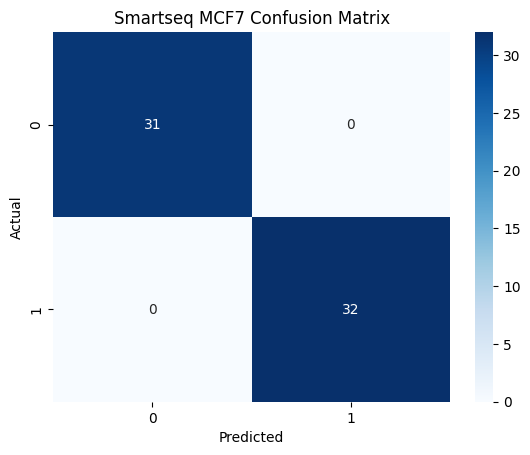

    Accuracy: 1.0

In \[ \]:

    conf_matrix([[24, 0], [2, 19]], "Smartseq HCC1806")

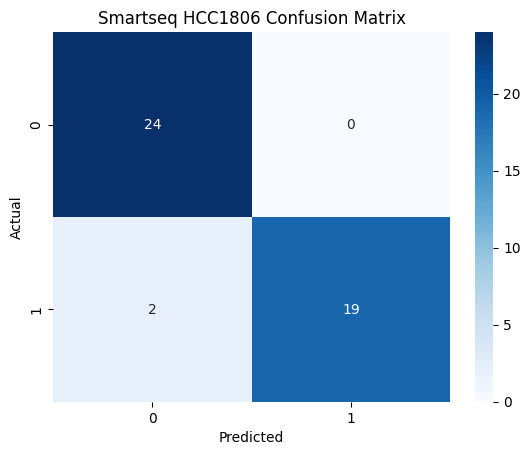

    Accuracy: 0.9555555555555556

In \[ \]:

    conf_matrix([[3175,46], [40, 2145]], "Dropseq MCF7")

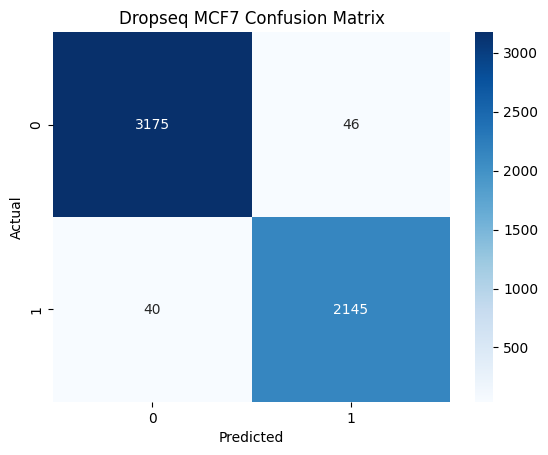

    Accuracy: 0.9840917499075101

In \[ \]:

    conf_matrix([[1378,79], [76,2138]], "Dropseq HCC1806")

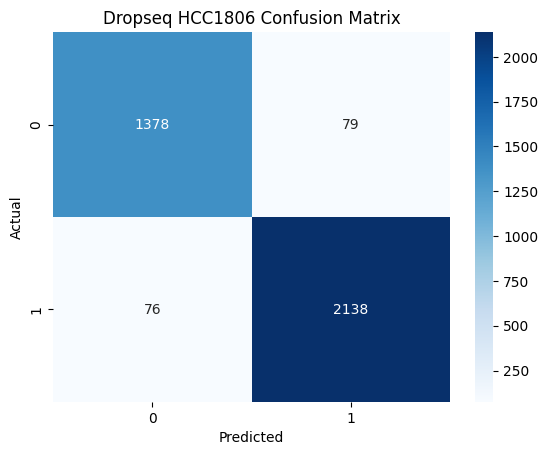

    Accuracy: 0.9577771724325796

Looking at the above confusion matrices we have a clear visual
representation of our various models' performance. Specifically we can
see how the best overall on the SmartSeq MCF7 was the Logistic
Regression with an accuracy of 100%. Looking, on the other hand, at the
SmartSeq HCC1806 accuracy achieved by the Logistic Regression we can
still see a very good score of 96%. Moving onwards to the DropSeq
datasets we can generally see a slightly worse (but still very
promising) performance whereby the LGBMClassifier achieved a performance
of 98% and 96% accuracy respectively on MCF7 and HCC1806. When
considering the very rapid training speeds when training and moreover
fine tuning these models and then seeing the generally very high
performance (95%+ for all models) on a completely unknown dataset we can
conclude that the project allowed us to reach very good results.